# Roboterprogrammierung WS 25/26 - Flyby Optimization

## Authors

- Marlon Leitschuh  -   lema1046@h-ka.de
- Pascal Pawliczek  -   papa1021@h-ka.de
- Nico Sander       -   sani1019@h-ka.de


## Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import math
import ipywidgets as widgets
from IPython.display import display

# Make the src/ directory available
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from planners.IPBasicPRM import BasicPRM
from planners.IPPerfMonitor import IPPerfMonitor
from optimize_path import OptimizeFlyby
from collision_checker import CollisionChecker
from benchmarks import construct_benchmark_environments
from evaluation import calculate_path_length, plot_performance_data, clear_graph_attributes

## Load Environments

Das Erstellen der 4 Benchmarkszenen aus Aufgabe 1 ist in der Funktion `construct_benchmark_environments()` in der Python Datei `benchmarks.py` im `src/` Ordner ausgelagert.

In [2]:
env_dict = construct_benchmark_environments()

## Create Planner and Collision Checker for each environment

In [3]:
for name, item in env_dict.items():
    # 1. Initialize a CollisionChecker with the environment
    cc = CollisionChecker(item["env"])  # Erfüllt Aufgabe 1 a)

    # 2. Initialize a Planner with the collisionChecker
    planner = BasicPRM(cc)  # Erfüllt Aufgabe 1 b)

    # 3. Construct the NetworkX Graph from the predefined solution path
    G = nx.Graph()

    node_names = []

    for i, coord in enumerate(item["smooth_path"]):
        # Determine the name based on position in the list
        if i == 0:
            n = "start"
        elif i == len(item["smooth_path"]) - 1:
            n = "goal"
        else:
            n = f"{i}" # Naming middle nodes generically
        
        node_names.append(n)
        
        # Add node with the 'pos' attribute
        G.add_node(n, pos=coord)

    # Add edges connecting each node to the next
    for i in range(len(node_names) - 1):
        current_node = node_names[i]
        next_node = node_names[i+1]
        G.add_edge(current_node, next_node)

    # 4. Inject the constructed graph into the Planner instance
    planner.graph = G   # Erfüllt Aufgabe 1 c)
    
    # 5. Add the node names and the planner to the environment dictionary
    env_dict[name]["solution_node_names"] = node_names      # Erfüllt Aufgabe 1 d)
    env_dict[name]["planner"] = planner
    del env_dict[name]["smooth_path"]

## Show the Environments

In den Plots die durch die folgende Zelle erstellt werden ist zu sehen, dass die Anmerkungen aus Aufgabe 1 erfüllt werden:
- Alle Pfade besitzen mindestens 5 Punkte
- Aufeinanderfolgende Pfadsegmente sind verschieden lang (siehe Environment 2)

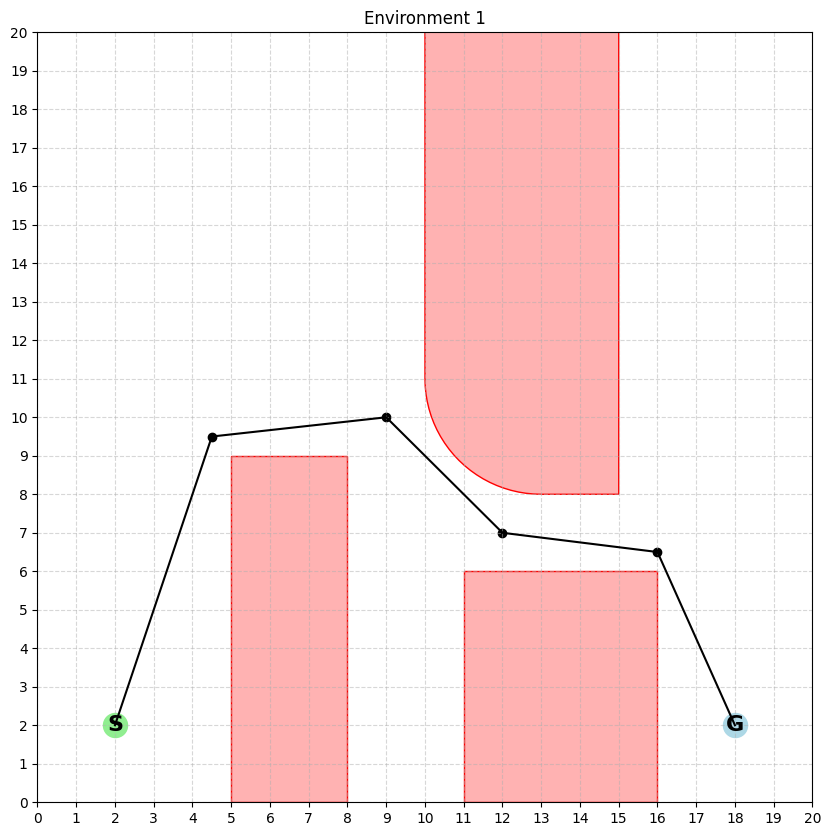

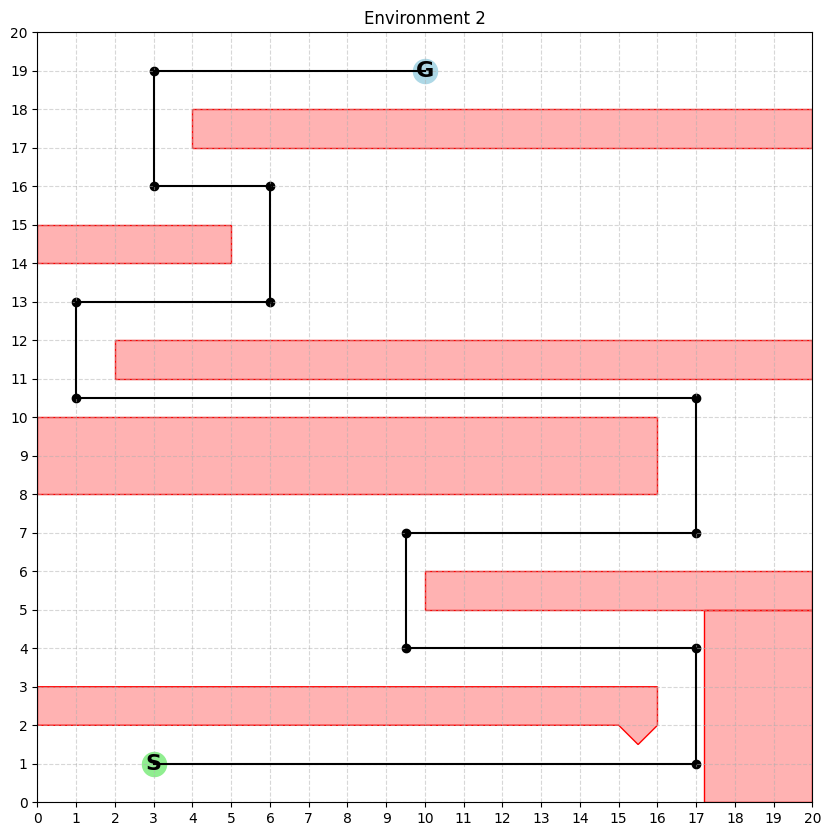

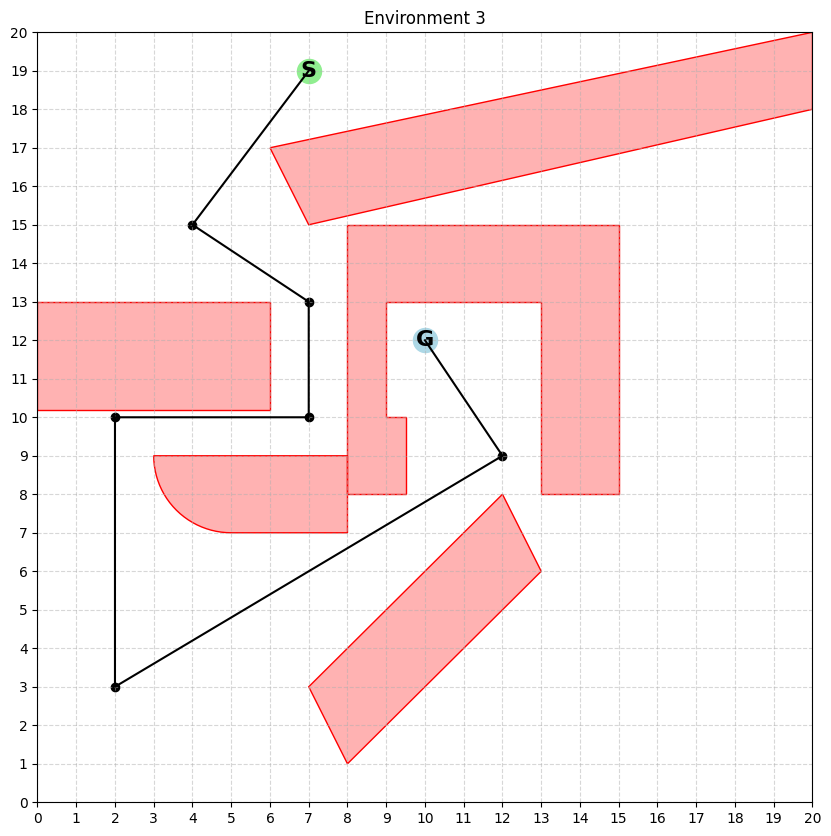

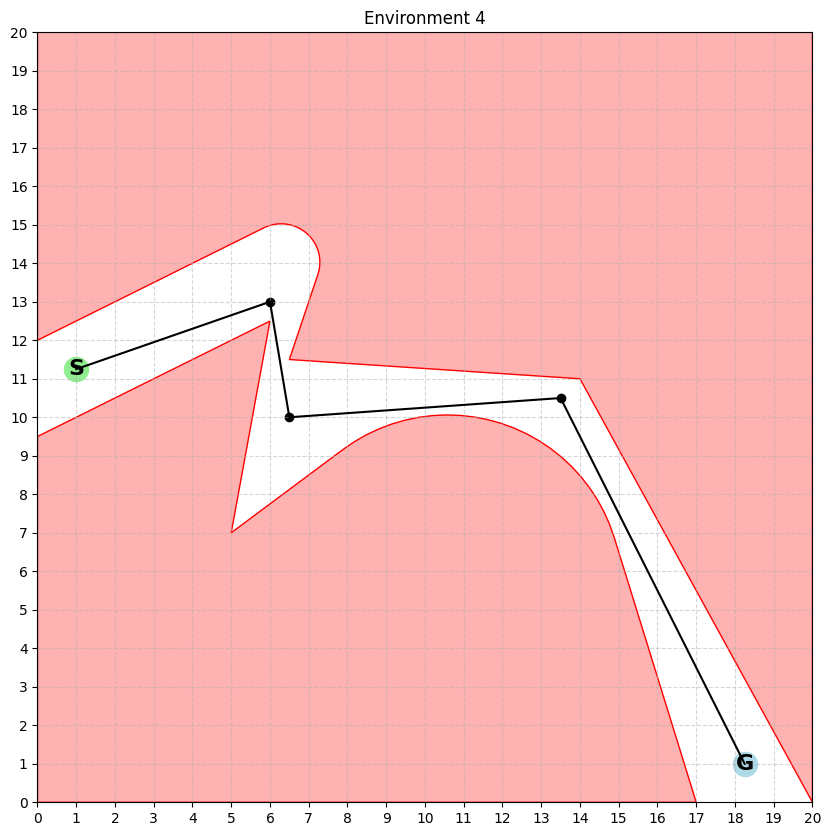

In [4]:
for name, item in env_dict.items():
    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc = planner._collisionChecker

    # Extract the positions of the nodes in the solution path
    pos = [planner.graph.nodes[node_name]["pos"] for node_name in node_names]

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the path
    ax = cc.draw_path(pos, ax=ax)

    # Set the title
    ax.set_title(f"Environment {name}")

    # Show the plot
    plt.show()

## Optimize the path by setting a radius $r$

- Die in Aufgabe 2 zu erstellende Klasse `OptimizeFlyby` mit der vorgegebenen Signatur und der Methode `optimizePath` kann in der Python Datei `optimize_path.py` im `src/` Ordner gefunden werden.

- Die folgenden beiden Code-Zellen implementieren die Anforderungen aus Aufgabe 2 a). In der darauf folgenden Zelle wird noch untersucht, wie sich der Parameter $r$ auf die Pfadlänge auswirkt.

- Ein Plot der die Performance der Pfadoptimierung (Anzahl und Zeit der Aufrufe für die Kollisions-Checks pointInCollision, lineInCollision und curveIneCollision) und die Länge der optimierten Pfade im Vergleich zu den Originalpfaden zeigt, ist den Plots der Environments mit optimiertem Pfad angehängt. Somit wird Aufgabe 2 c) erfüllt.

- Dannach folgt die schriftliche Diskussion und Erklärung der Methode `optimizePath()` der Klasse `OptimizeFlyby` sowie die schriftliche Analyse der Performance Plots.

- Zur Berechnung und dem Vergleich der Pfadlängen ist in der Python Datei `evaluation.py` im `src/` Ordner die Funktion `calculate_path_length()` implementiert.

- Die in Aufgabe 2 b) geforderte Visualisierungsfunktion ist Teil der Klasse `CollisionChecker` und heißt `draw_optimized_path()`. Der *CollisionChecker* wird in der Python Datei `collision_checker.py` implementiert.

### Configure the radius and step by using the sliders

In [5]:
r_slider = widgets.FloatSlider(
    value=0.49,      # Default
    min=0.02, 
    max=0.49, 
    step=0.01,
    description='r:',
    continuous_update=False
)

r_step_slider = widgets.FloatSlider(
    value=0.02,      # Default
    min=0.01, 
    max=0.1, 
    step=0.01,
    description='r step:',
    continuous_update=False
)

display(r_slider)
display(r_step_slider)

FloatSlider(value=0.49, continuous_update=False, description='r:', max=0.49, min=0.02, step=0.01)

FloatSlider(value=0.02, continuous_update=False, description='r step:', max=0.1, min=0.01, step=0.01)

### Run the optimization using the $r$ values from the slider

----------------------------------------
Optimizing Environment 1 with config:
    r_init: 0.49
    r_step: 0.02
----------------------------------------


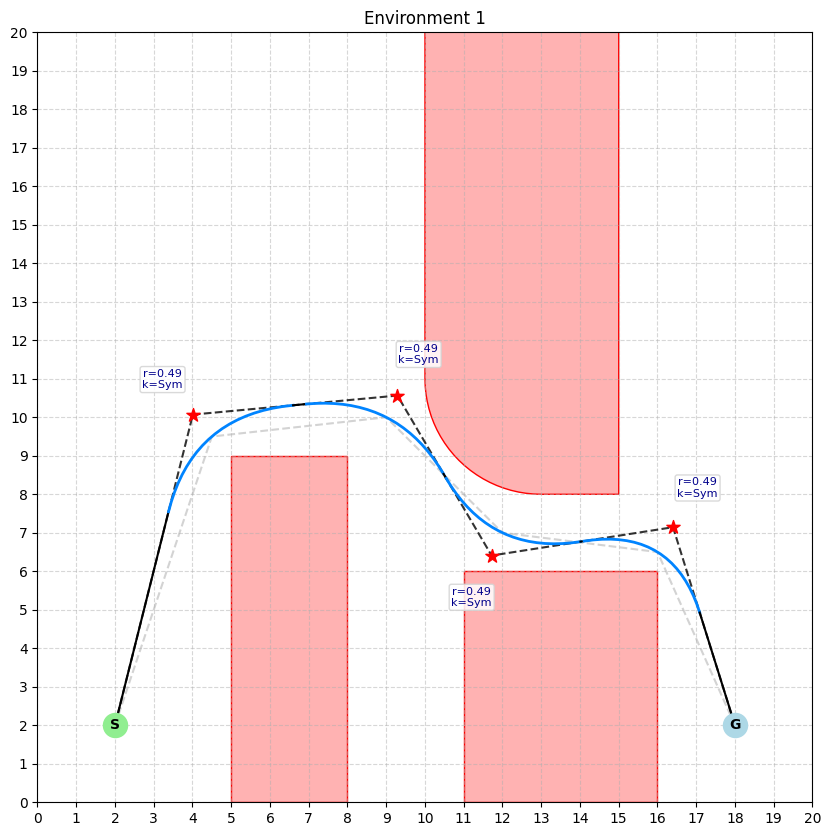

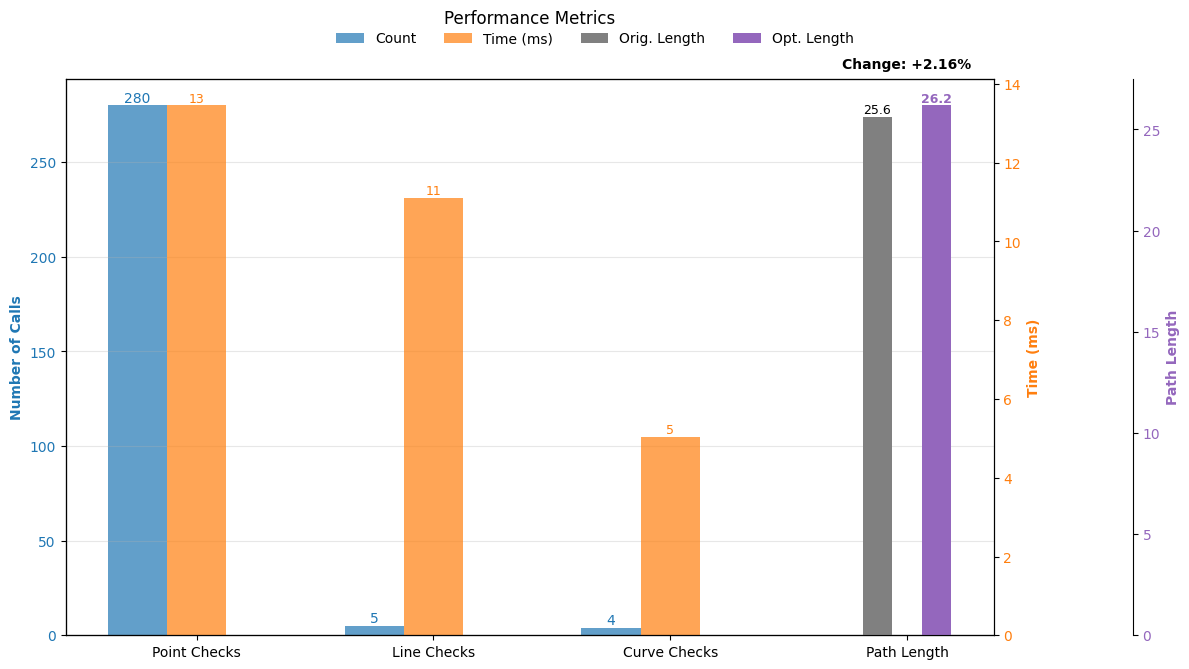

----------------------------------------
Optimizing Environment 2 with config:
    r_init: 0.49
    r_step: 0.02
----------------------------------------


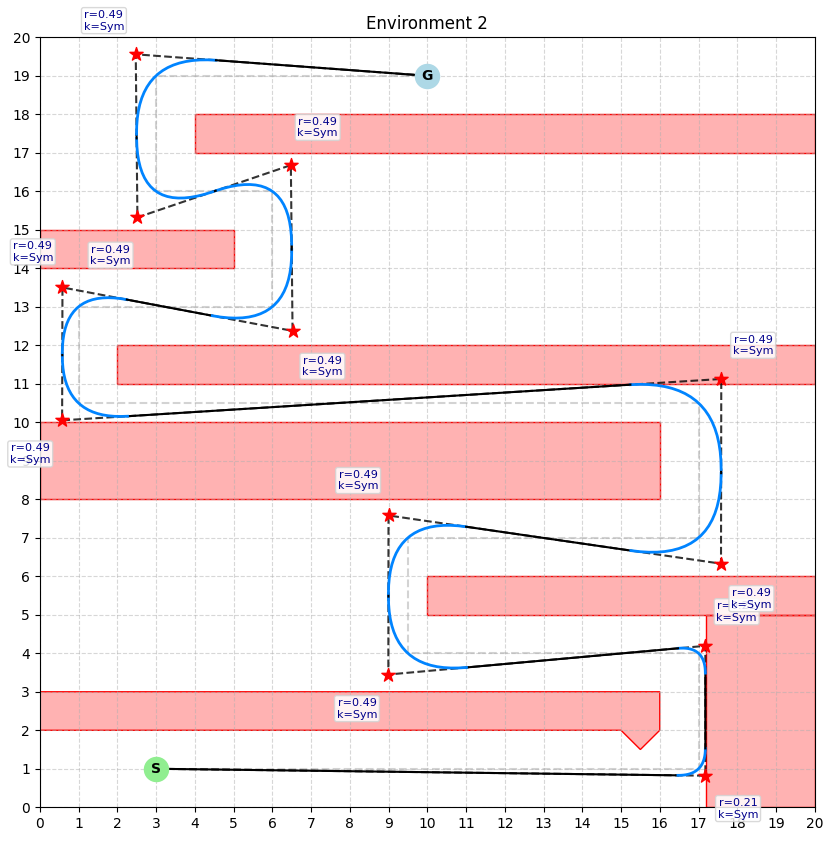

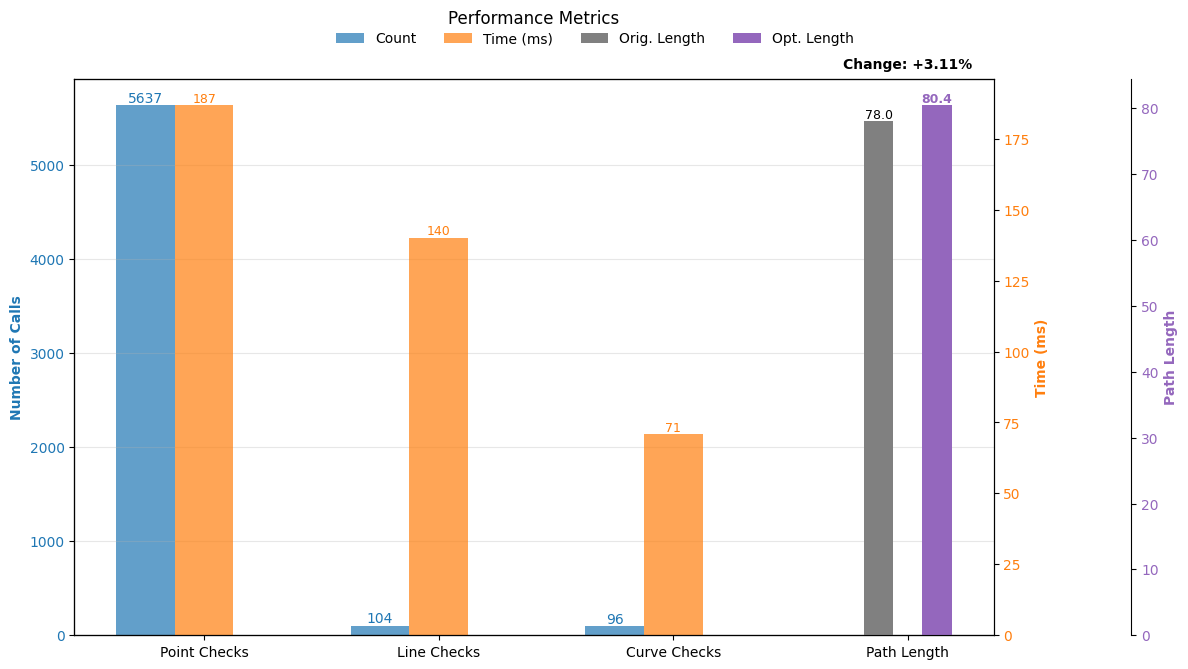

----------------------------------------
Optimizing Environment 3 with config:
    r_init: 0.49
    r_step: 0.02
----------------------------------------


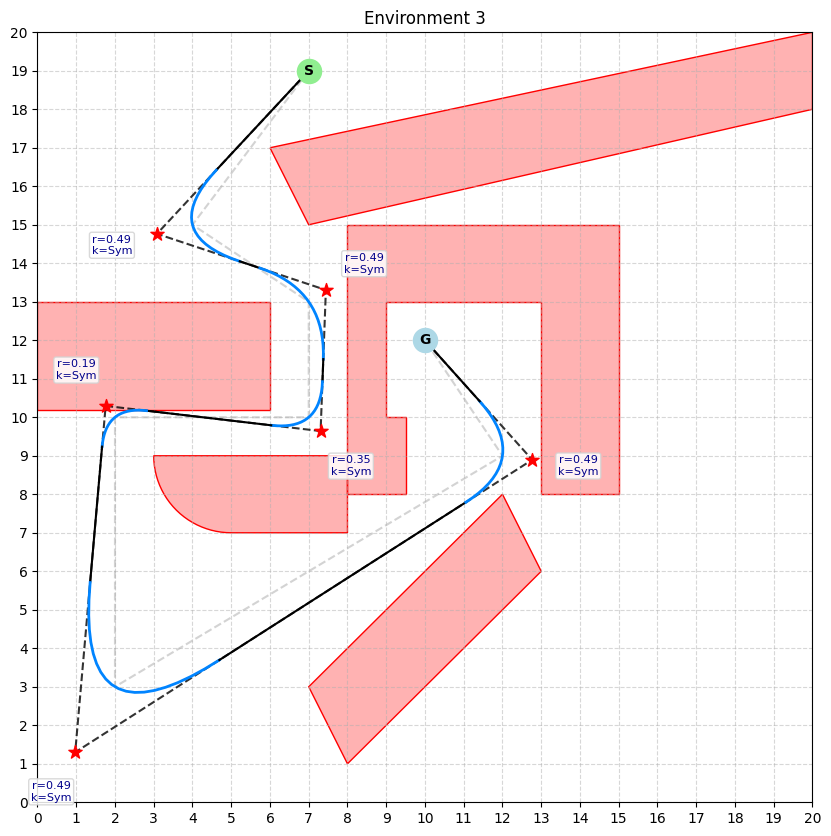

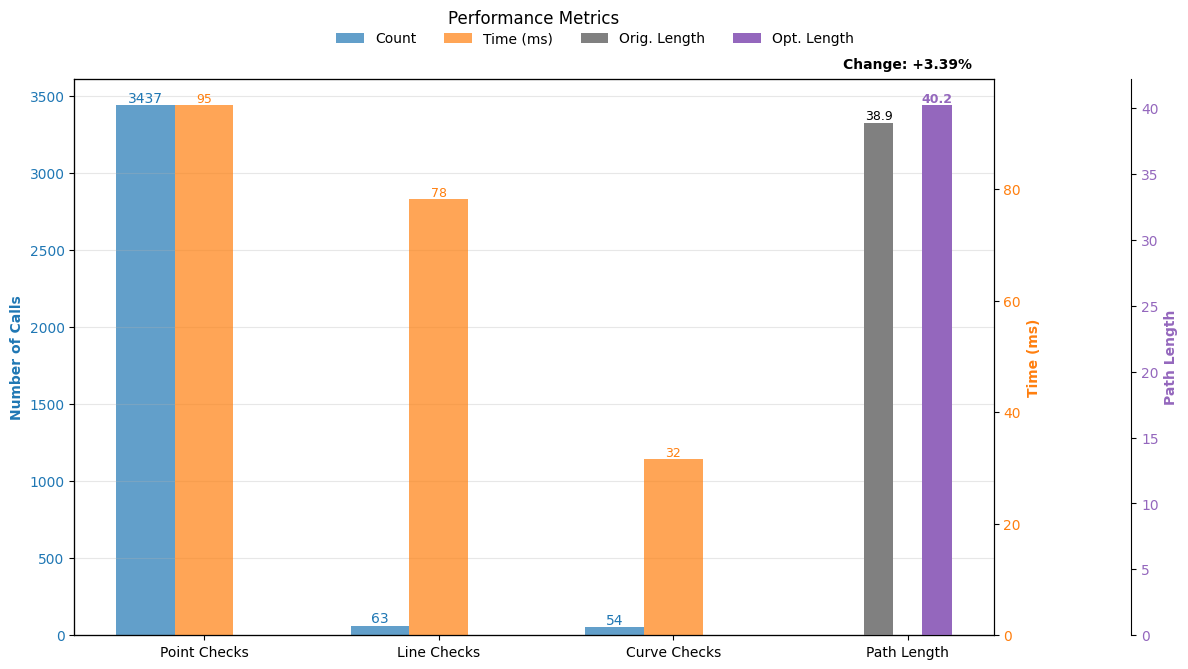

----------------------------------------
Optimizing Environment 4 with config:
    r_init: 0.49
    r_step: 0.02
----------------------------------------


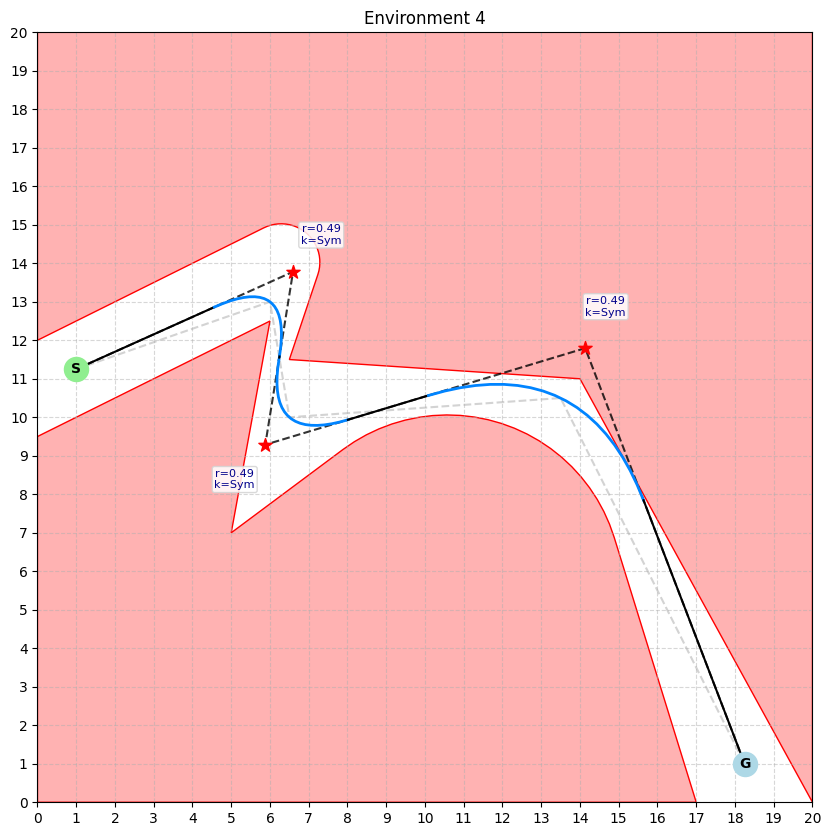

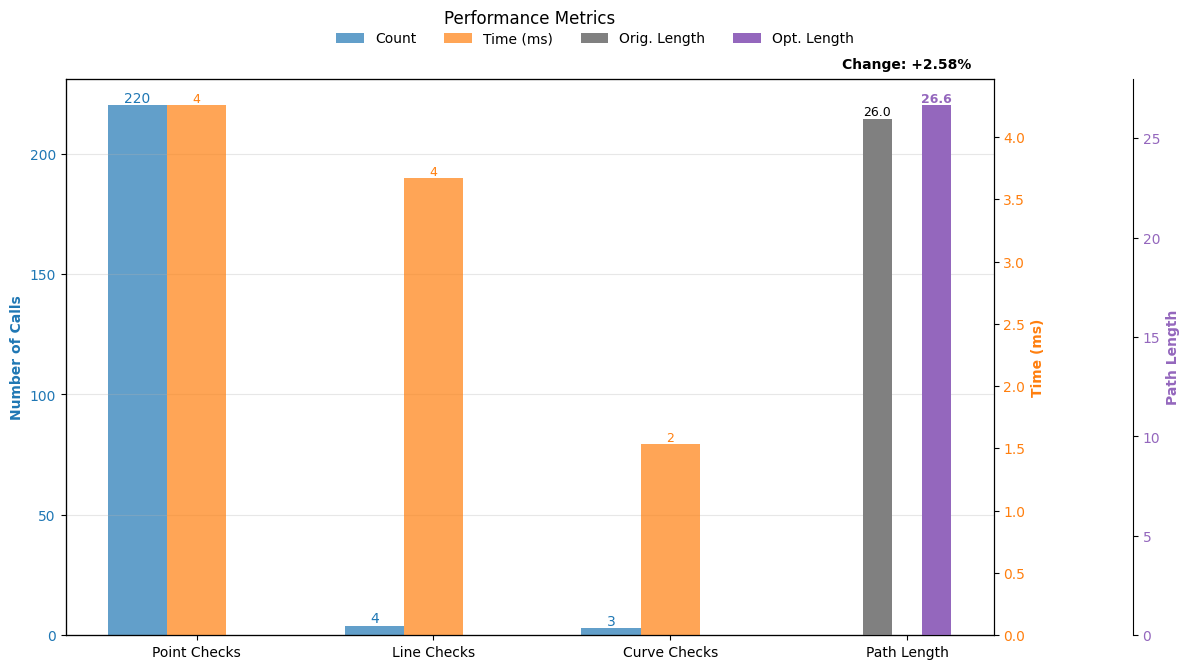

In [6]:
# Configure the Optimizer with slider values
config = {
    'r_init': round(r_slider.value, 2),
    'r_step': round(r_step_slider.value, 2),
}


for name, item in env_dict.items():
    print(f"{40 * '-'}")
    print(f"Optimizing Environment {name} with config:")
    print(f"    r_init: {config['r_init']}")
    print(f"    r_step: {config['r_step']}")
    print(f"{40 * '-'}")


    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Clear the Performance Monitor
    IPPerfMonitor.clearData()

    # Clear graph attributes
    clear_graph_attributes(planner)

    # Measure the total time for later analysis
    start_time = time.time()

    # Run the optimizer
    results = optimizer.optimizePath(node_names, planner, config)

    # Store the time for the optimization in the env_dict for later analysis
    end_time = time.time()
    item['symmetric_time'] = end_time - start_time


    # Get the performance data
    df = IPPerfMonitor.dataFrame

    # Extract the performance data for plotting
    df = IPPerfMonitor.dataFrame()
    stats = {}
    target_funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    
    for f in target_funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {
                'count': len(f_data), 
                'time': f_data['time'].sum()
            }
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate original path length
    len_orig = calculate_path_length(planner, node_names, use_curves=False)

    # Store the orignal path length in the env_dict for later analysis
    item['orignal_path_length'] = len_orig

    # Calculate optimized path length (of rounded path)
    len_opt = calculate_path_length(planner, node_names, use_curves=True)

    # Store the optimized path length in the env_dict for later analysis
    item['symmetric_path_length'] = len_opt

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the optimized path
    ax = cc.draw_optimized_path(results, planner, ax)

    # Set the title
    ax.set_title(f"Environment {name}")

    # Show the plot
    plt.show()

    # Plot the performance data
    plot_performance_data(stats, len_orig, len_opt)

## Show the dependency of the path length over $r$

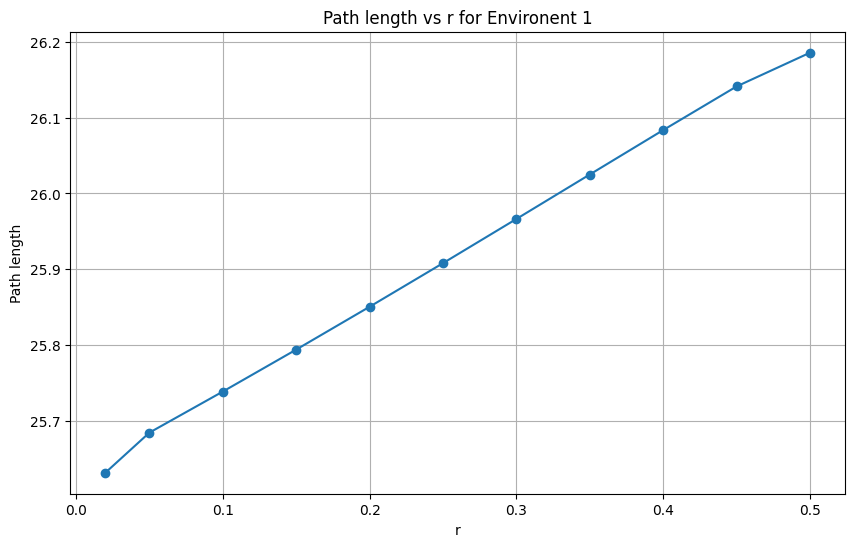

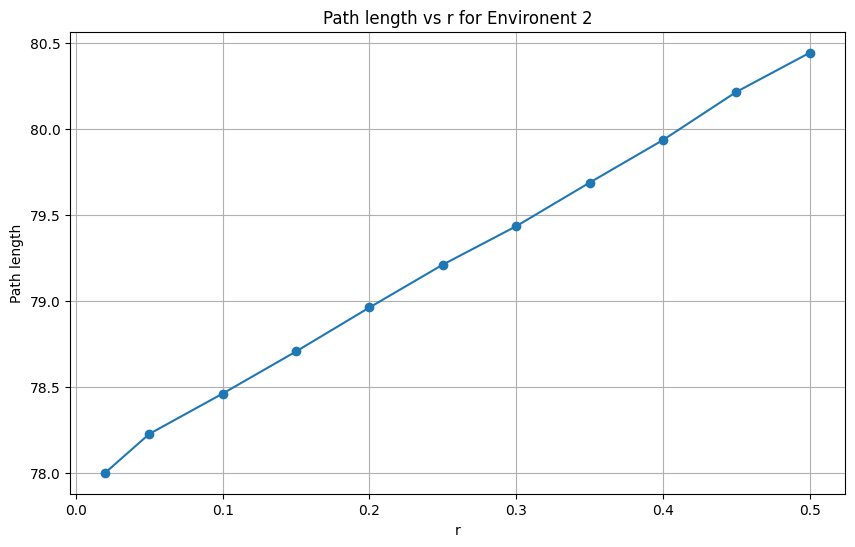

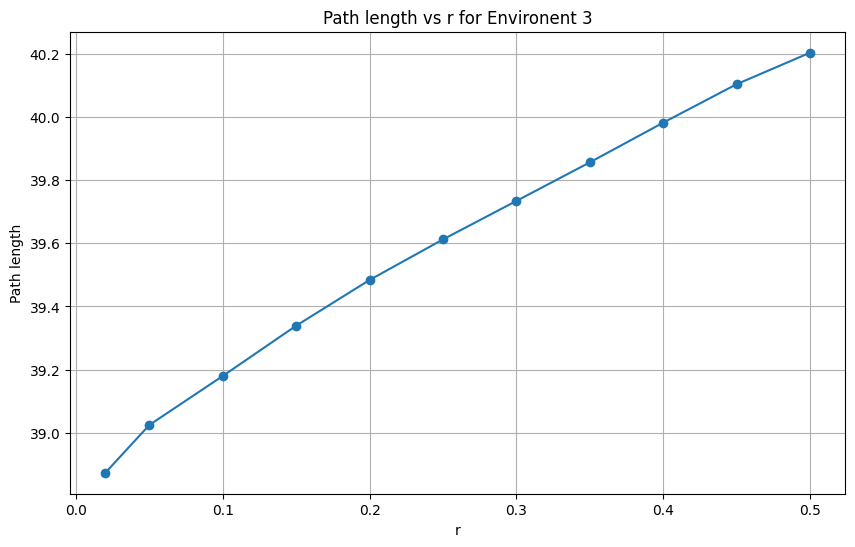

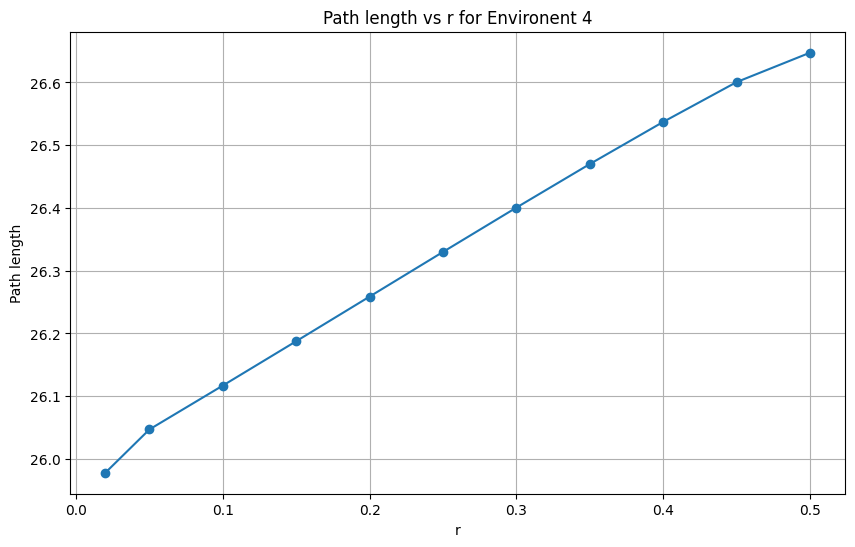

In [7]:
# Define the sweep range for the radius parameter
r_steps = np.linspace(0.05, 0.5, 10)
# Clean up the values (rounding and removing duplicates) and include a very small radius (0.02) as a baseline
r_values = sorted(list(set([0.02] + list(np.round(r_steps, 2)))))

for name, item in env_dict.items():
    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Initialize a list for the path lengths
    path_lengths = []

    for r in r_values:
        # Clear graph attributes
        clear_graph_attributes(planner)

        # Optimize the path for the current r
        results = optimizer.optimizePath(node_names, planner, config={"r_init": r})

        path_lengths.append(calculate_path_length(planner, node_names))

    # Plot the path length vs. r
    plt.figure(figsize=(10, 6))
    plt.plot(r_values, path_lengths, marker='o', linestyle='-')
    plt.title(f"Path length vs r for Environent {name}")
    plt.xlabel("r")
    plt.ylabel("Path length")
    plt.grid(True)
    plt.show

## Optimierungsstrategie und Kollisionsbehandlung (Aufgabe 2a)

Die Glättung des initialen, stückweise linearen Pfades erfolgt durch die Implementierung der Klasse `OptimizeFlyby` und deren Hauptmethode `optimizePath`. Ziel des Verfahrens ist es, die abrupten Richtungsänderungen an den Wegpunkten durch $G^1$-stetige Übergänge zu ersetzen, wobei quadratische Bézier-Kurven zum Einsatz kommen. Die Strategie lässt sich in zwei wesentliche Phasen unterteilen: die Berechnung der virtuellen Kontrollpunkte (Relaxation) und die iterative Kollisionsbereinigung.

### 1. Berechnung der Pfadgeometrie durch Relaxation (Inverse Rounding)

Ein naives "Abrunden" der Ecken würde dazu führen, dass der Roboter den ursprünglichen Wegpunkt ($P_{org}$) "schneidet" und somit den Pfad verkürzt, was in engen Umgebungen zu Kollisionen an der Innenseite der Kurve führen kann. Um dies zu verhindern, implementiert der Algorithmus das Verfahren des **Inverse Rounding**.

Hierbei wird für jeden Knoten ein neuer, virtueller Kontrollpunkt $P_{2n}$ berechnet. Dieser Punkt wird so weit nach außen verschoben, dass der Scheitelpunkt der resultierenden Bézier-Parabel exakt den ursprünglichen Wegpunkt $P_{org}$ berührt. Die Berechnung folgt der Formel:

$$
P_{2n} = \frac{4 \cdot P_{org} - l_i \cdot P_{prev} - l_o \cdot P_{next}}{4 - l_i - l_o}
$$

Eine besondere Herausforderung, die die Methode `optimizePath` lösen muss, ist die gegenseitige Abhängigkeit der Punkte. Die Position des optimalen Kontrollpunkts $P_{2n}$ eines Knotens hängt von den Positionen seiner Nachbarn ($P_{prev}$ und $P_{next}$) ab. Da sich diese Nachbarn im selben Schritt ebenfalls verschieben, um ihre eigenen Kurven zu optimieren, entsteht ein gekoppeltes System.

Zur Lösung dieses Problems wendet der Algorithmus eine **Relaxations-Strategie** an. In einer inneren Schleife wird die Berechnung der Kontrollpunkte mehrfach (standardmäßig 15 Iterationen) über den gesamten Pfad hinweg wiederholt. Dies ermöglicht es den virtuellen Positionen, sich entlang der Kette zu propagieren und zu einem stabilen Zustand zu konvergieren, bevor die eigentliche Geometrie validiert wird.

### 2. Strategie zur Kollisionsbehandlung

Nachdem die ideale Geometrie basierend auf dem aktuellen Glättungsradius $r$ berechnet wurde, erfolgt die Validierung durch den `CollisionChecker`. Die Strategie zur Behandlung von Kollisionen ist **iterativ und degressiv**.

Initial wird jedem Knoten der konfigurierbare Radius `r_init` (maximal und standartmäßig $0.49$) zugewiesen. Der Algorithmus prüft anschließend in jedem Durchlauf der äußeren Optimierungsschleife vier kritische Bereiche auf Kollisionen:

1.  Das lineare Segment vom Startknoten zur ersten Kurve.
2.  Die linearen Verbindungssegmente zwischen den Kurvenenden ($E_{i}$) und den Kurvenanfängen ($S_{i+1}$).
3.  Das lineare Segment von der letzten Kurve zum Ziel.
4.  Die diskretisierten Bézier-Kurven selbst (überprüft mittels `curveInCollision`).

**Anpassungsstrategie bei Kollision:**
Sobald eine Kollision in einem Segment oder einer Kurve detektiert wird, wird der Pfad als ungültig markiert. Anstatt die Glättung für diesen Knoten vollständig zu verwerfen, wird der Radius $r$ für den betroffenen Knoten schrittweise um einen Wert `r_step` (konfigurierbar, standardmäßig $0.01$) reduziert.

* **Kollision in der Kurve:** Tritt eine Kollision direkt in der Kurve eines Knotens auf, wird nur dessen Radius verringert (`r_map[node] -= r_step`).
* **Kollision auf der Verbindungsstrecke:** Tritt eine Kollision auf dem geraden Segment zwischen dem Ende einer Kurve und dem Anfang der nächsten Kurve auf, werden die Radien **beider** angrenzenden Knoten reduziert.
    
    > **Hintergrund:** 
        Die Verbindungsstrecke weicht durch die Glättung vom ursprünglichen, kollisionsfreien Pfad ab. Durch das Verringern der Radien ziehen sich die Kurven näher an ihre ursprünglichen Eckpunkte zurück. Dadurch verschieben sich auch Start- und Endpunkt der Verbindungsstrecke wieder näher hin zum ursprünglichen Pfadsegment, welches garantiert hindernisfrei ist.

Da jede Änderung eines Radius die Geometrie und damit auch die Position der virtuellen Kontrollpunkte beeinflusst, erfordert eine Anpassung einen erneuten Durchlauf der Relaxationsphase. Dieser gesamte Zyklus wird iterativ so lange wiederholt (`max_iterations`), bis ein vollständig kollisionsfreier Pfad vorliegt oder die Radien ihren definierten Minimalwert (`r_min`) unterschreiten. Dies gewährleistet, dass der Algorithmus für jede Kurve konvergiert und dabei den maximal möglichen Radius beibehält, den die Hinderniskonstellation zulässt.

## Evaluation und Diskussion der Ergebnisse (Aufgabe 2c)

Zur Evaluierung des implementierten Verfahrens wurden die vier Benchmark-Szenarien herangezogen. Dabei wurden systematisch verschiedene Glättungsradien ($r$) getestet und deren Auswirkung auf die Pfadlänge, die Anzahl der Kollisionsberechnungen und die Rechenzeit analysiert.

### Analyse der Pfadlänge im Vergleich zum Originalpfad

Ein zentrales Ergebnis der Untersuchung ist das Verhältnis zwischen dem gewählten Radius $r$ und der resultierenden Gesamtlänge des Pfades.

* **Verlängerung durch Inverse Rounding:** Im Gegensatz zu klassischen Glättungsverfahren (z. B. einfaches Corner Cutting), welche den Pfad durch das "Abschneiden" von Ecken verkürzen, führt das hier implementierte **Inverse Rounding** zu einer **Verlängerung** der Wegstrecke gegenüber dem ursprünglichen, stückweise linearen Pfad.
* **Begründung:** Die Optimierungsstrategie erzwingt, dass die glättende Parabel den ursprünglichen Wegpunkt $P_{org}$ berührt (siehe Aufgabe 2a). Um dies bei steigendem Radius $r$ zu gewährleisten, muss der virtuelle Kontrollpunkt $P_{2n}$ geometrisch weiter nach außen geschoben werden. Der Roboter fährt also effektiv einen größeren Bogen *um* die theoretische Ecke herum, anstatt sie abzukürzen.
* **Linearer Zusammenhang:** Die Auswertungen (siehe "Radius Impact Analysis" Plot) zeigen eine näherungsweise lineare Korrelation zwischen dem Radius und der Pfadlänge. Dies entspricht der geometrischen Erwartung, da die Distanzverschiebung der Kontrollpunkte linear von den Parametern $l_i$ und $l_o$ abhängt, welche wiederum direkt proportional zu $r$ sind.

### Kollisionsberechnungen und Rechenzeit

Die Anzahl der Kollisionsberechnungen und die damit verbundene Rechenzeit korrelieren stark mit der Komplexität der Umgebung (Anzahl der Knoten) und dem gewählten Initialradius `r_init`.

* **Einfluss des Radius:** Wählt man einen sehr großen Initialradius in einer engen Umgebung (z. B. Benchmark 2 oder 4), steigt die Wahrscheinlichkeit, dass die weit nach außen geschobenen Kontrollpunkte oder die resultierenden Kurvensegmente in Hindernisse ragen.
* **Iterative Kosten:** Sobald eine Kollision detektiert wird, greift die in Aufgabe 2a beschriebene Reparaturstrategie (Reduktion von $r$). Dies erzwingt jedoch erneute Durchläufe der Optimierungsschleife, was die Anzahl der nötigen Kollisionschecks (`curveInCollision`, `lineInCollision`) und somit die Gesamtrechenzeit erhöht.
* **Vergleich:** In offenen Arealen (Teile von Benchmark 1) erfolgt die Berechnung nahezu instantan, da der initiale Radius sofort akzeptiert wird. In engen Passagen steigen die Berechnungskosten, bis der Radius so weit reduziert wurde, dass die Kurve kollisionsfrei ist.

### Zusammenfassende Diskussion

Das Verfahren erzeugt erfolgreich $G^1$-stetige Pfade, die für den Roboter ohne Stopps abfahrbar sind. Der Preis für das Beibehalten der ursprünglichen Wegpunkte (via points) ist eine Verlängerung der Strecke. Dies ist jedoch in vielen Anwendungsfällen (z. B. wenn der Wegpunkt eine Arbeitsstation oder ein Tor markiert, das exakt durchfahren werden muss) eine notwendige Eigenschaft. Das Verfahren stellt somit einen Kompromiss dar: Maximale Glätte (großes $r$) führt zu längeren Wegen und potenziell höheren Berechnungskosten in engen Umgebungen.

---

## Optimize the path by setting a radius $r$ and a global asymmetry factor $k$

In den folgenden Zellen werden die Ergebnisse von Aufgabe 2 d) ausgewertet. Den Plots für jedes Environment folgen auch hier die Plots der Performance Analyse, die die Anzahl und die Rechenzeit der Kollisions-Checks zeigen und resultierende Pfadlänge mit der Länge des Originalpfades vergleichen.

### Configure the radius, step and k by using the sliders

In [9]:
r_slider = widgets.FloatSlider(
    value=0.49,      # Default
    min=0.02, 
    max=0.49, 
    step=0.01,
    description='r:',
    continuous_update=False
)

r_step_slider = widgets.FloatSlider(
    value=0.02,      # Default
    min=0.01, 
    max=0.1, 
    step=0.01,
    description='r step:',
    continuous_update=False
)

k_slider = widgets.FloatSlider(
    value=1.0,      # Default
    min=0.1, 
    max=3.0, 
    step=0.2,
    description='k:',
    continuous_update=False
)


display(r_slider)
display(r_step_slider)
display(k_slider)

FloatSlider(value=0.49, continuous_update=False, description='r:', max=0.49, min=0.02, step=0.01)

FloatSlider(value=0.02, continuous_update=False, description='r step:', max=0.1, min=0.01, step=0.01)

FloatSlider(value=1.0, continuous_update=False, description='k:', max=3.0, min=0.1, step=0.2)

----------------------------------------
Optimizing Environment 1 with config:
    r_init: 0.49
    r_step: 0.02
    k: 1.0
----------------------------------------


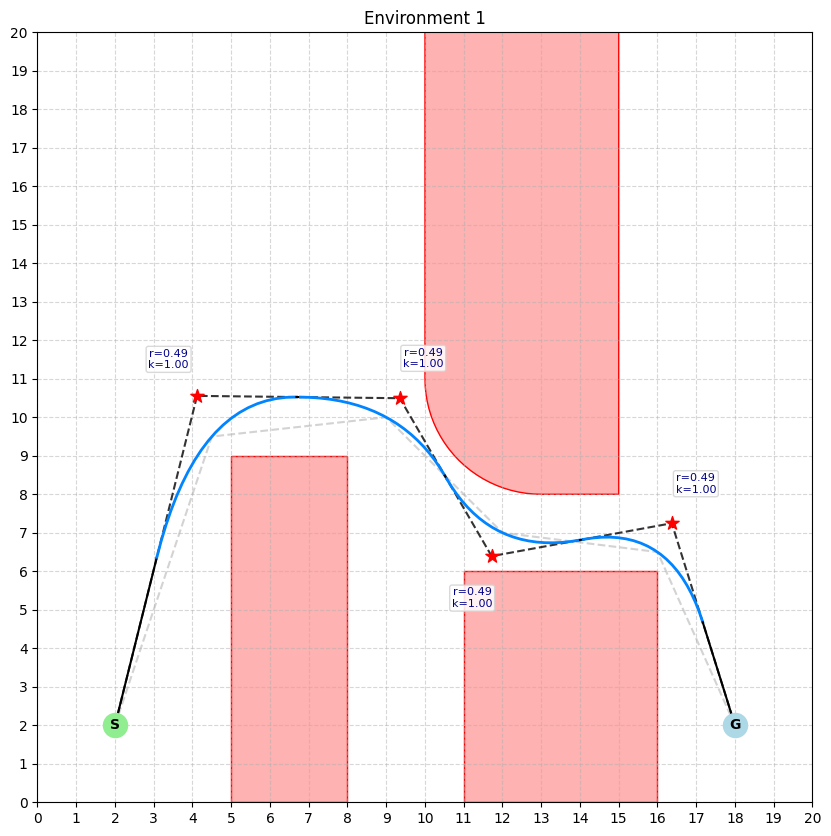

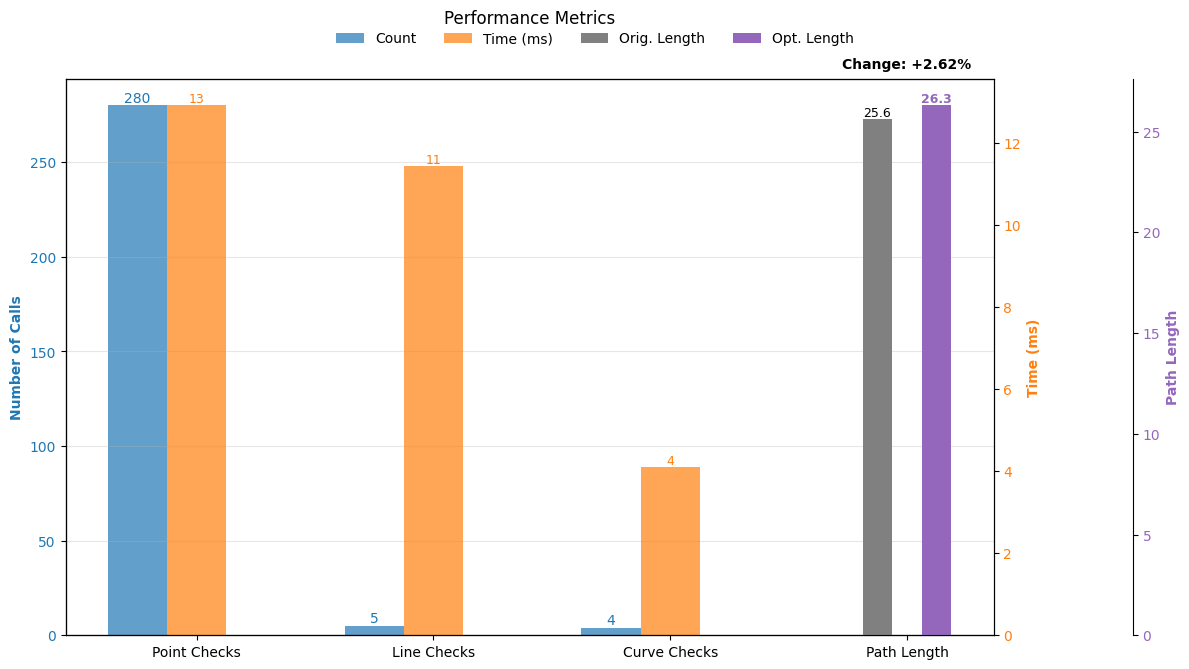

----------------------------------------
Optimizing Environment 2 with config:
    r_init: 0.49
    r_step: 0.02
    k: 1.0
----------------------------------------


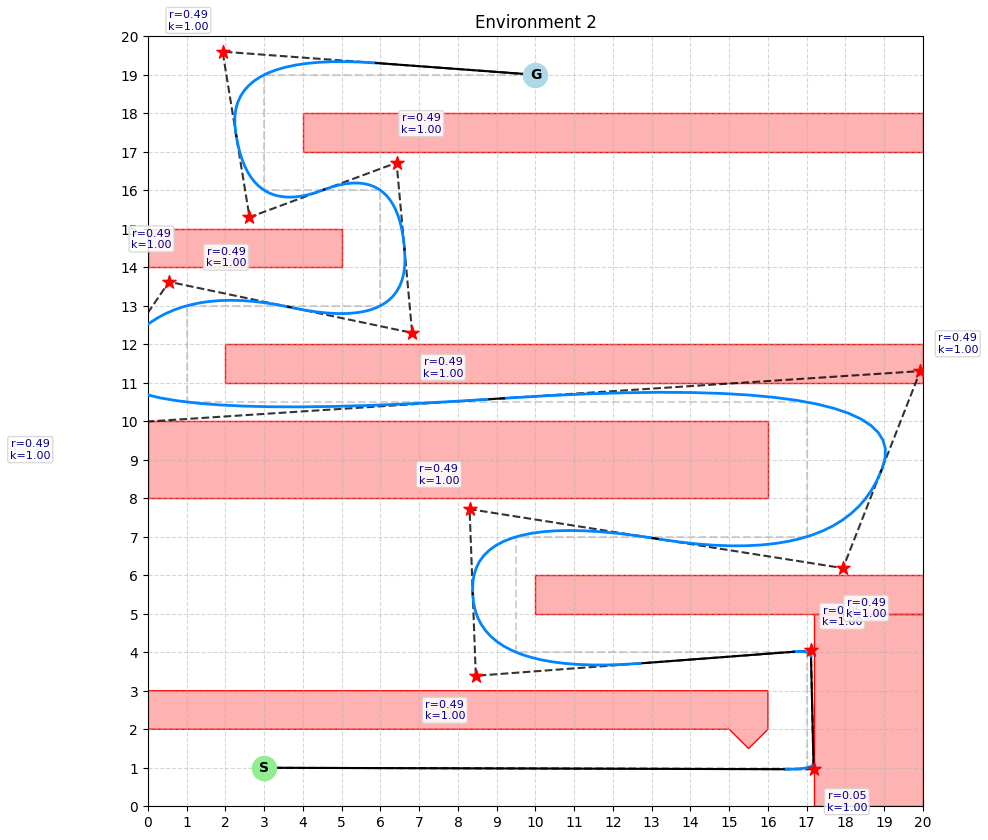

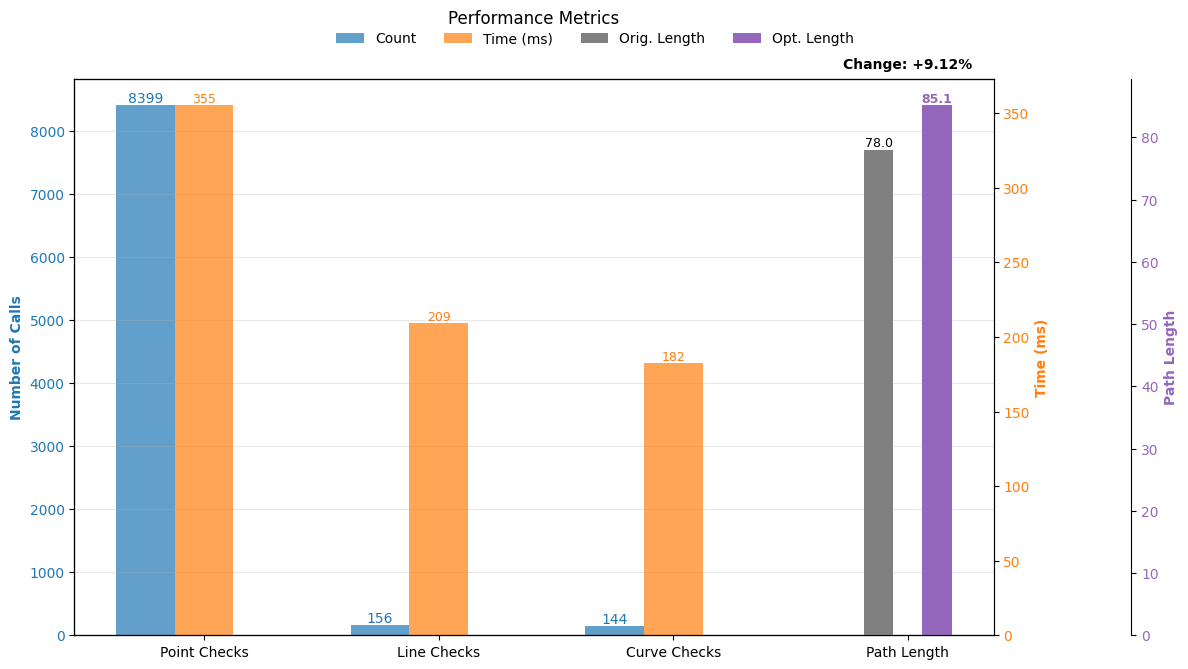

----------------------------------------
Optimizing Environment 3 with config:
    r_init: 0.49
    r_step: 0.02
    k: 1.0
----------------------------------------


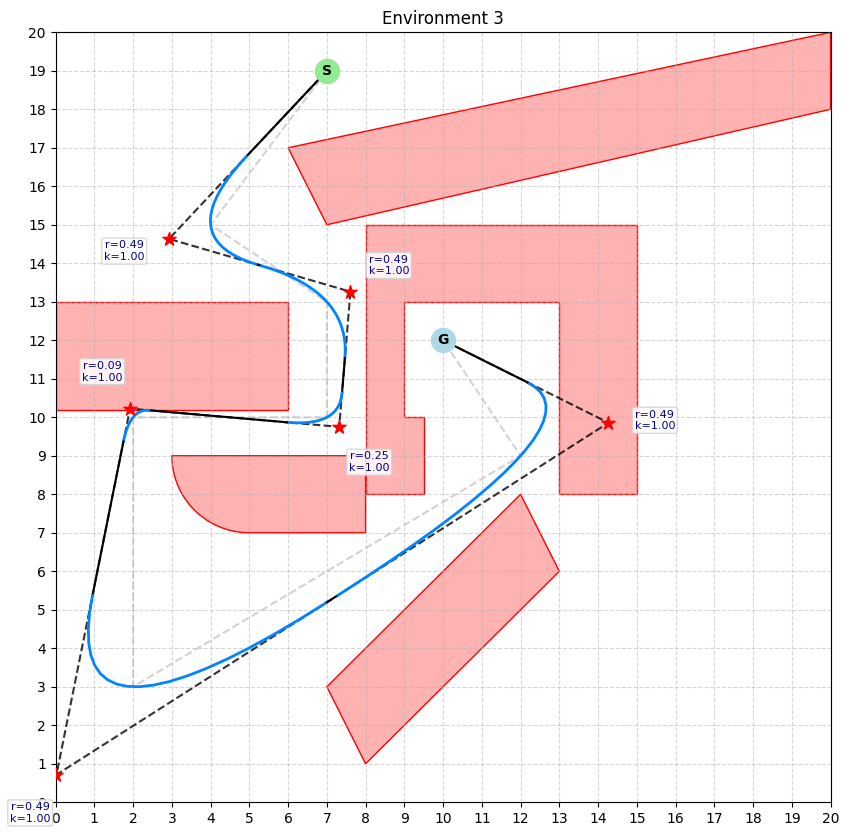

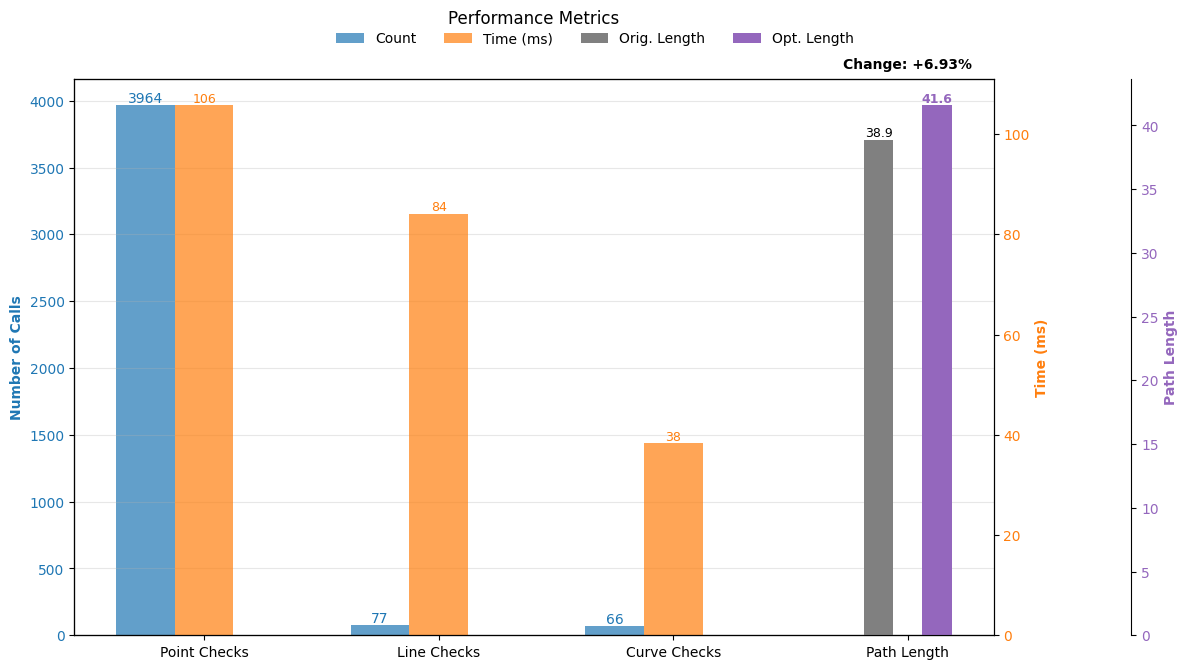

----------------------------------------
Optimizing Environment 4 with config:
    r_init: 0.49
    r_step: 0.02
    k: 1.0
----------------------------------------


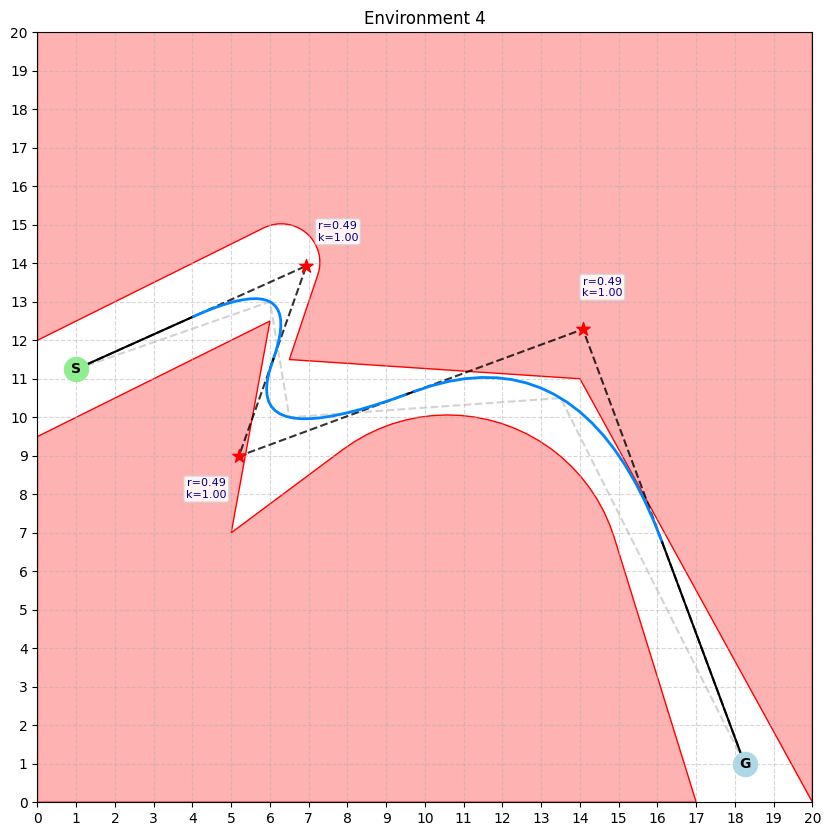

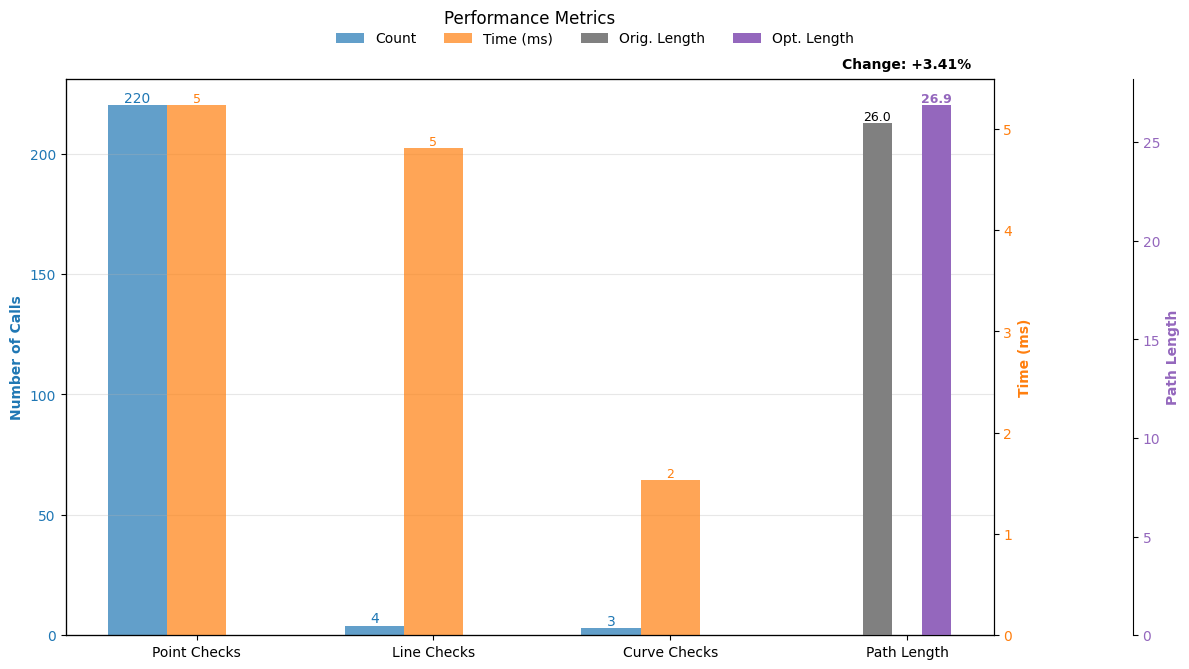

In [10]:
# Configure the Optimizer with slider values
config = {
    'r_init': round(r_slider.value, 2),
    'r_step': round(r_step_slider.value, 2),
    'k': round(k_slider.value, 2)
}


for name, item in env_dict.items():
    print(f"{40 * '-'}")
    print(f"Optimizing Environment {name} with config:")
    print(f"    r_init: {config['r_init']}")
    print(f"    r_step: {config['r_step']}")
    print(f"    k: {config['k']}")
    print(f"{40 * '-'}")

    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Clear the Performance Monitor
    IPPerfMonitor.clearData()
    
    # Clear graph attributes
    clear_graph_attributes(planner)

    # Run the optimizer
    results = optimizer.optimizePath(node_names, planner, config)

    # Get the performance data
    df = IPPerfMonitor.dataFrame

    # Extract the performance data for plotting
    df = IPPerfMonitor.dataFrame()
    stats = {}
    target_funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    
    for f in target_funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {
                'count': len(f_data), 
                'time': f_data['time'].sum()
            }
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate original path length
    len_orig = calculate_path_length(planner, node_names, use_curves=False)

    # Calculate optimized path lengthe (of rounded path)
    len_opt = calculate_path_length(planner, node_names, use_curves=True)

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the optimized path
    ax = cc.draw_optimized_path(results, planner, ax)

    # Set the title
    ax.set_title(f"Environment {name}")

    # Show the plot
    plt.show()

    # Plot the performance data
    plot_performance_data(stats, len_orig, len_opt)


## Einfluss des Asymmetriefaktors $k$ (Aufgabe 2d)

Ergänzend zur Variation des Radius wurde die Konfiguration der Klasse `OptimizeFlyby` erweitert, um einen festen Asymmetriefaktor $k$ vorzugeben. Dieser Parameter modifiziert die Geometrie der Bézier-Parabeln, indem er das Verhältnis der Tangentenparameter am Kurveneingang und Kurvenausgang steuert.

### Implementierung und Wirkungsweise von $k$

In der Methode `optimizePath` definiert der Parameter $k$ das Verhältnis zwischen dem Parameter $l_i$ (für den Kurveneingang / "in") und $l_o$ (für den Kurvenausgang / "out"). Die Implementierung folgt der Beziehung:

$$
l_o = k \cdot l_i = k \cdot r
$$

Hierbei ist zu beachten, dass sich $k$ explizit als Skalierungsfaktor auf den **Kurvenausgang** bezieht. Ein $k > 1.0$ verlängert also den Tangentenabschnitt auf der Seite des ausgehenden Segments, während ein $k < 1.0$ ihn verkürzt.

### Unterschied zwischen dynamischer Symmetrie und $k=1.0$

Ein kritischer Aspekt bei der Evaluierung ist der Unterschied zwischen der Standardkonfiguration (`k=None`) und einer erzwungenen Symmetrie (`k=1.0`). Die Analyse des Codes zeigt, dass diese Modi fundamental unterschiedliche geometrische Eigenschaften erzeugen:

1.  **Dynamische / Geometrische Symmetrie (`k=None`):**
    Ist kein $k$ definiert, berechnet der Algorithmus die Tangentenpunkte so, dass der **absolute Abstand** (in Metern) vom Eckpunkt zum Startpunkt der Kurve ($S$) und zum Endpunkt der Kurve ($E$) identisch ist. Der Algorithmus orientiert sich dabei an der Länge des kürzeren Segments. Das Resultat ist ein geometrisch gleichschenkliges Dreieck an der Ecke.

2.  **Relative Symmetrie (`k=1.0`):**
    Wird $k=1.0$ gesetzt, bedeutet dies $l_o = l_i = r$. Da diese Parameter im Code jedoch als **Verhältnisfaktoren** (Prozentwerte der Segmentlänge) auf die Richtungsvektoren angewendet werden, sind die absoluten Abstände nur dann gleich, wenn auch die angrenzenden Pfadsegmente exakt gleich lang sind. Sind die Segmente unterschiedlich lang, liegen $S$ und $E$ zwar bei demselben prozentualen Anteil ihres jeweiligen Segments, haben aber unterschiedliche absolute Entfernungen zum Eckpunkt.

### Analyse der Ergebnisse der Tests mit verschiedenen Werten für k

1.  **Kollisions-Checks und Rechenzeit:**
    Das Verändern des Parameter $k$ hat nur bedingt Einfluss auf die Anzahl der Kollisionschecks und die Rechenzeit. Führt ein eingestellte Parameter $k$ zu ingesamt merh Kollisionen, muss $r$ verrringert werden, sodass ein Kollisionsfreier Pfad zustande kommen kann.

2.  **Einfluss auf die Pfadlänge:**
    Im allgemeinen wird die Pfadlänge durch einen global gesetzten Parameter $k$ größer. Dies liegt daran, dass die Kurvengeometrie einen großen Einfluss darauf hat, wie gut ein Wert $k$ zur Kurve passt und wie sehr hierdurch die Länge dieser Kurve verkürzt oder verlängert wird. Da die Benchmarkszenarien aus verschiedensten Kombinationen von Kurvengeometrien bestehen, für ein globaler Wert für $k$ zu längeren Pfaden als der symmetrische Fall.

---

## Optimize the global k for the path length

Um den globalen Wert für $k$ zu finden, der die Pfadlänge minimiert wurde die Methode `optimize_global_k()` innerhalb der `OptimizeFlyby` Klasse implementiert. Sie erfüllt die Anforderungen von Aufgabe 2 e). Die folgende Code-Zelle führt diese Optimierung für alle Benchmarkszenarien durch und zeigt dann sowohl die Plots der Pfade als auch die Performance Analyse.

Den Plots folgt dann unsere schriftliche Bewertung dieser Optimierung.

----------------------------------------
Optimizing Global k for Environment 1:
----------------------------------------


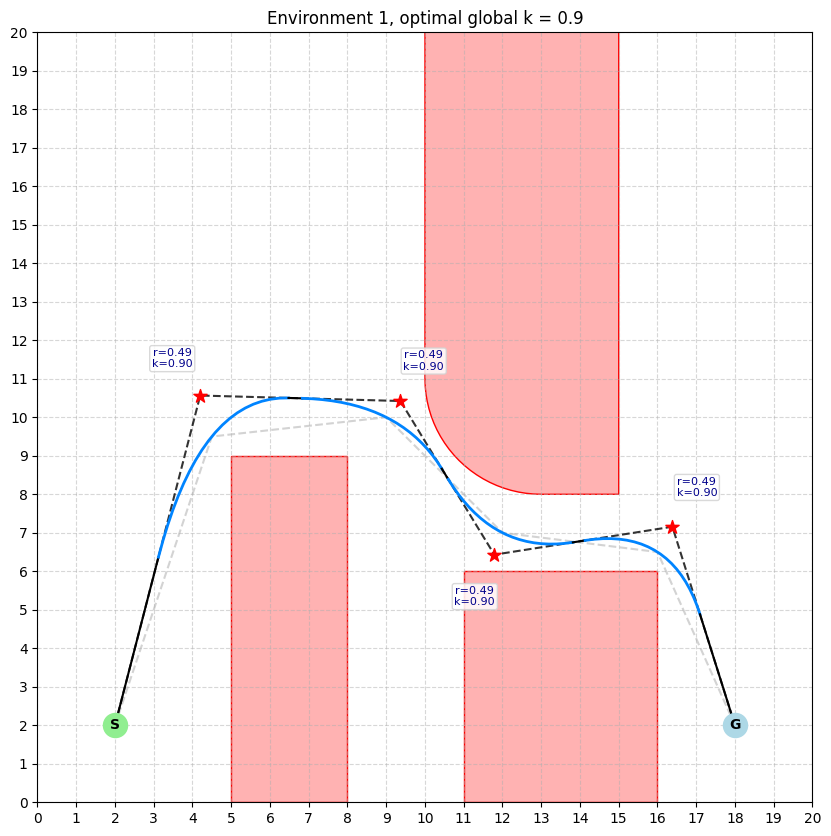

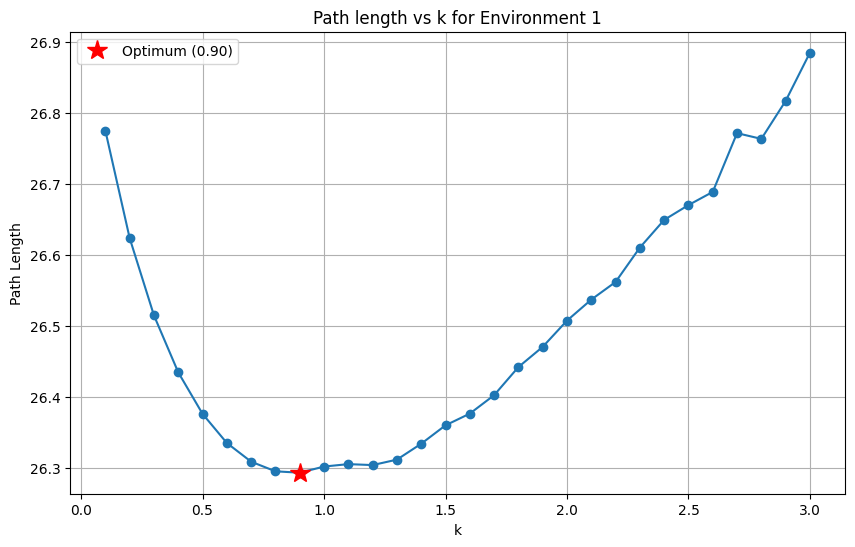

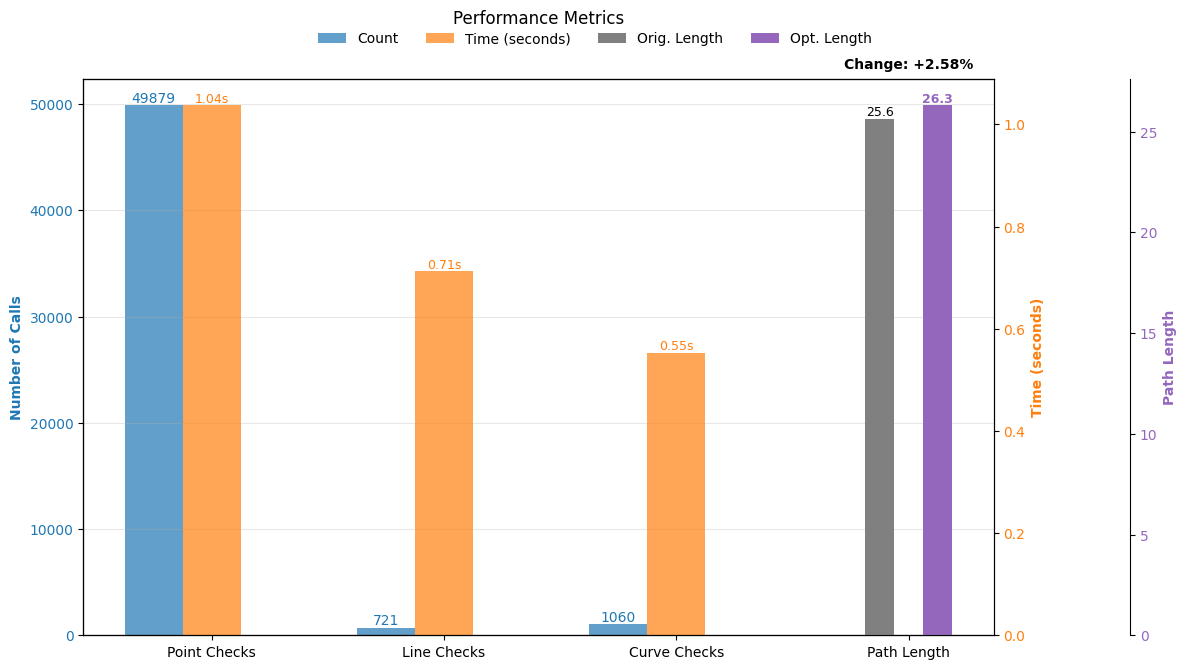

----------------------------------------
Optimizing Global k for Environment 2:
----------------------------------------


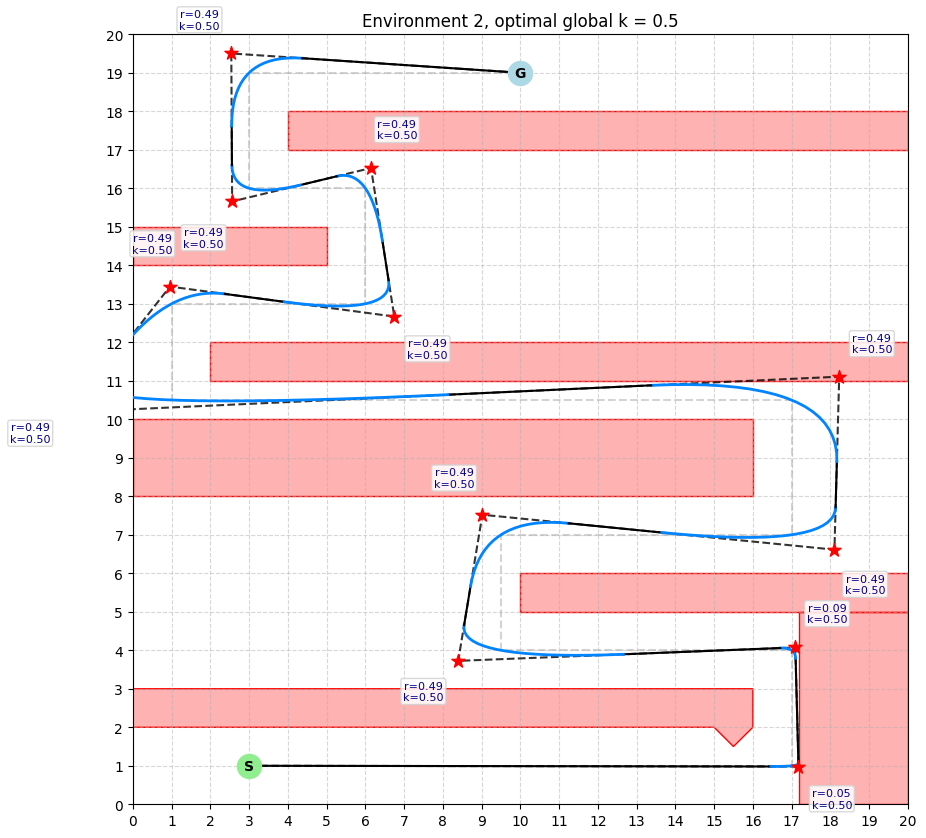

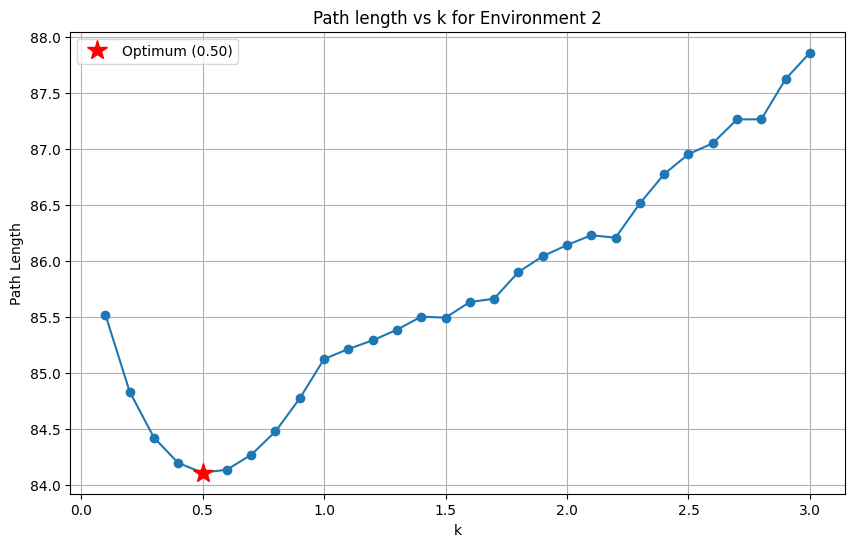

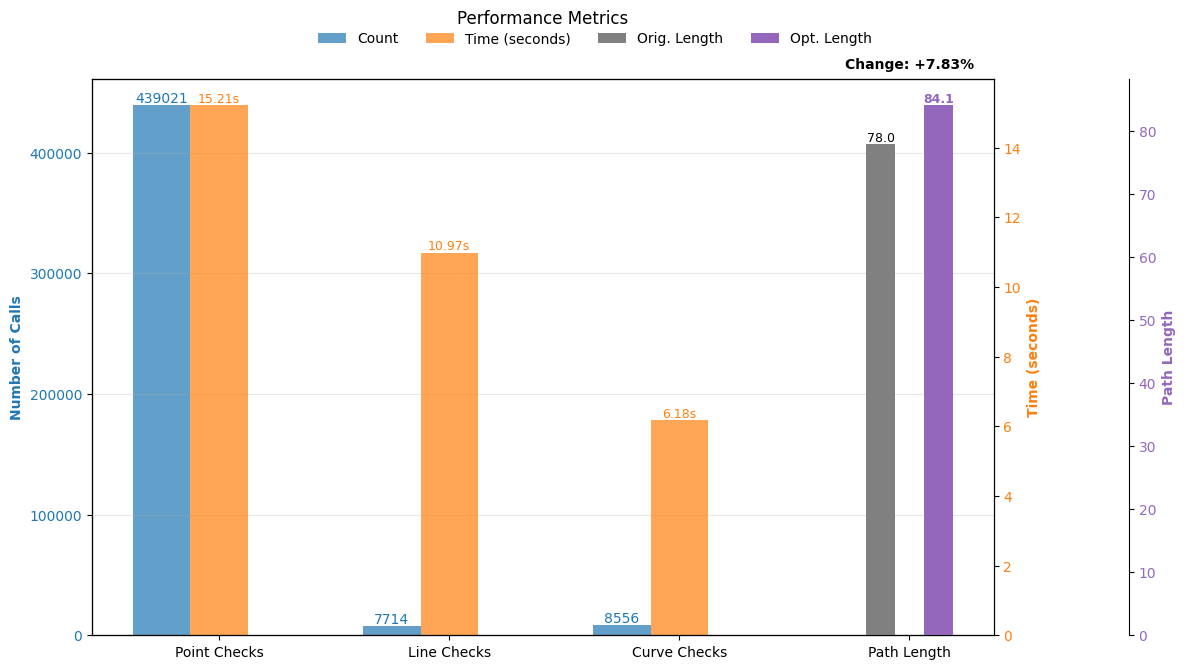

----------------------------------------
Optimizing Global k for Environment 3:
----------------------------------------


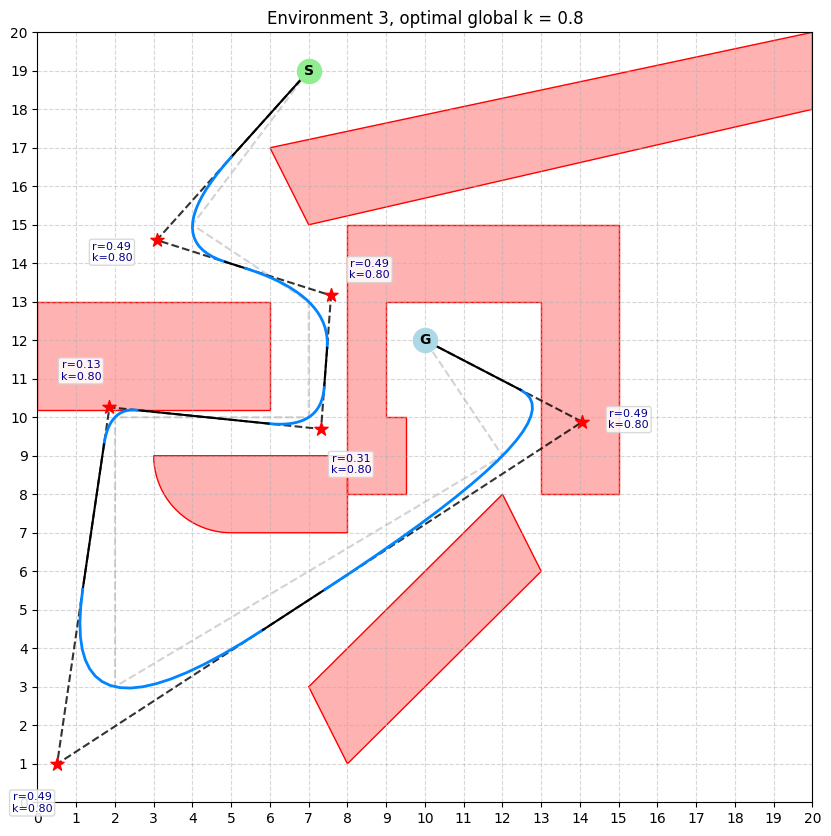

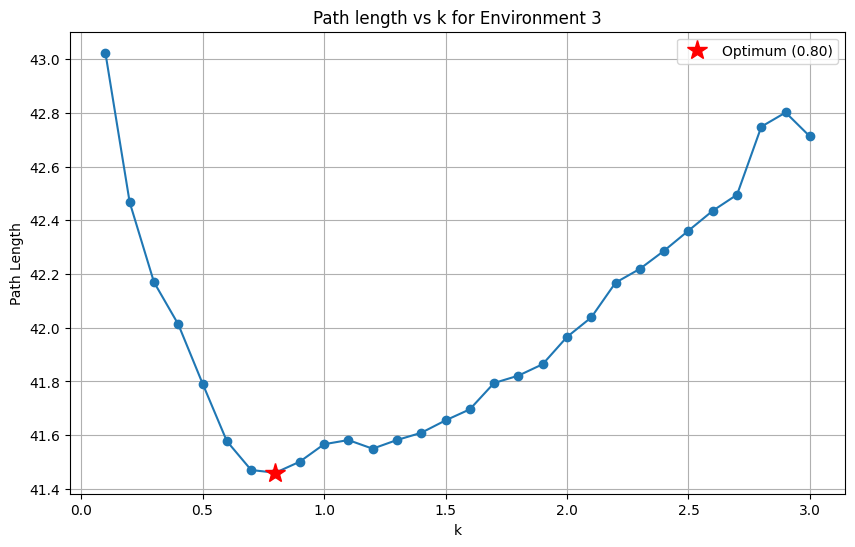

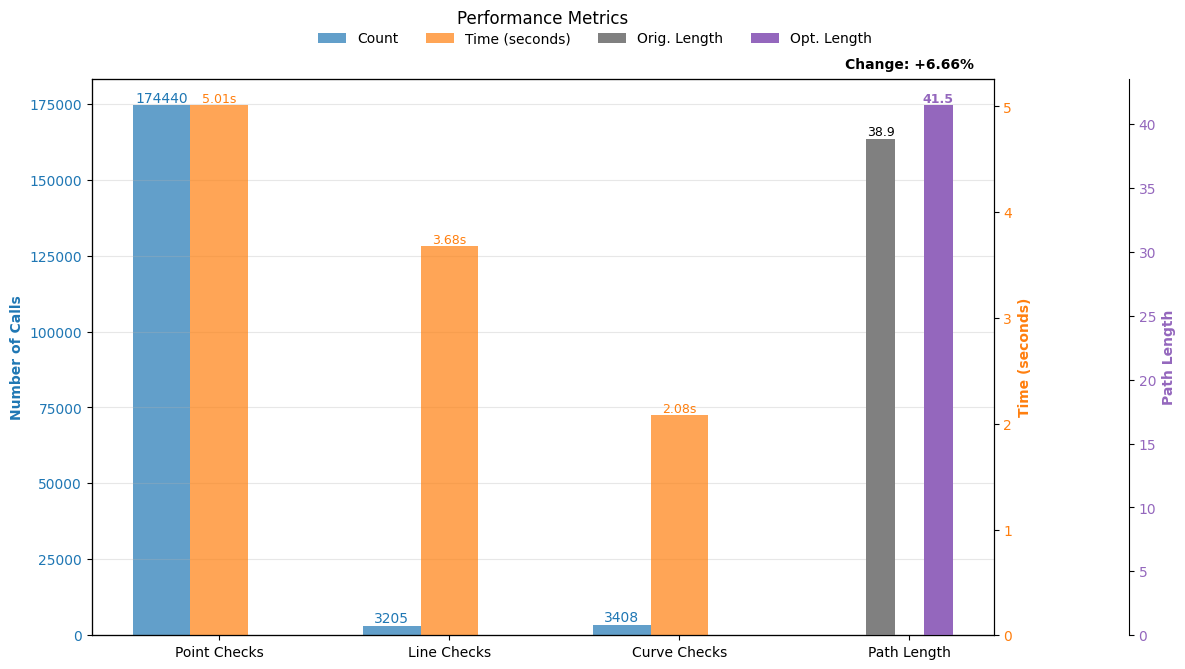

----------------------------------------
Optimizing Global k for Environment 4:
----------------------------------------


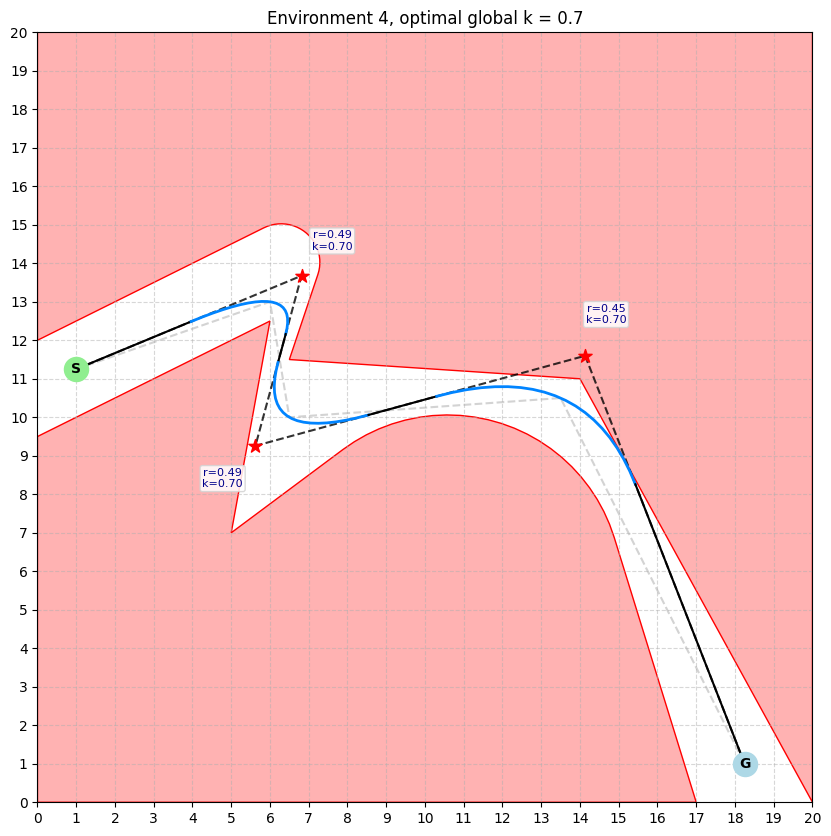

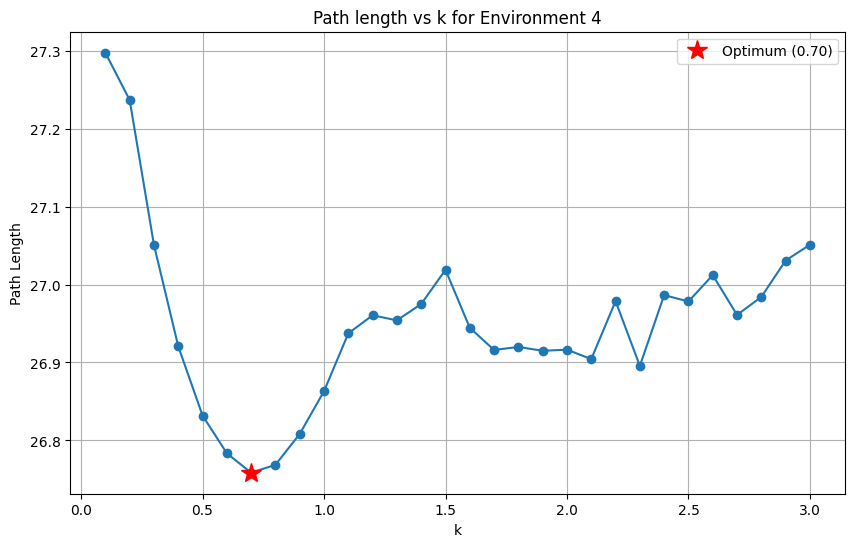

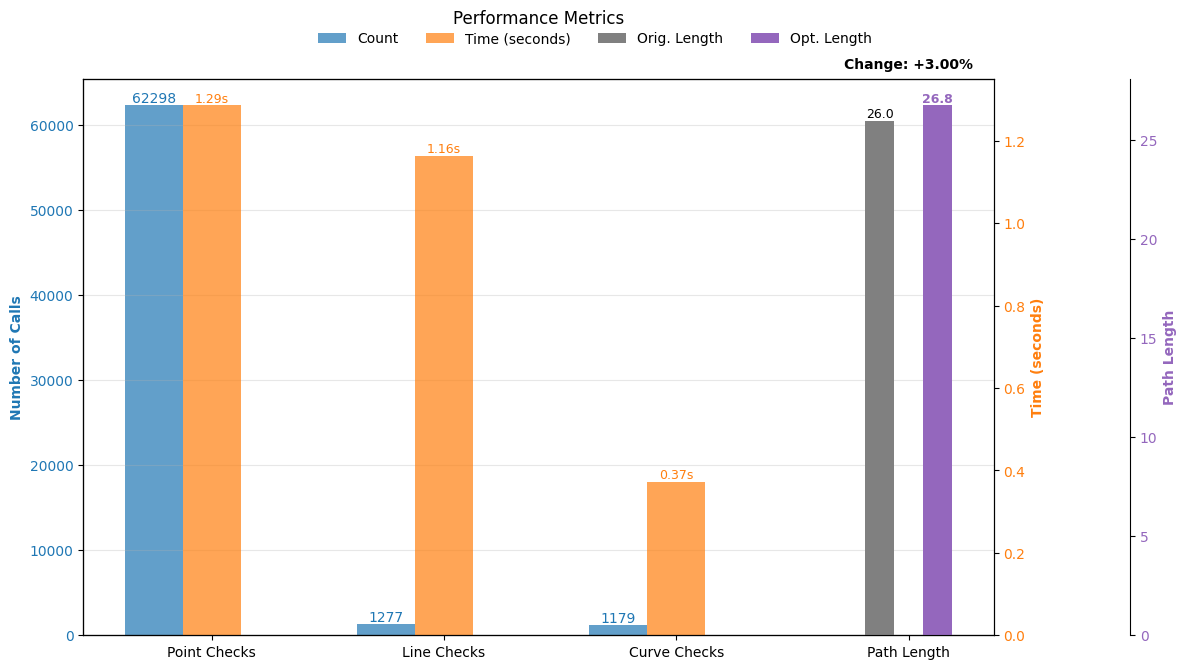

In [11]:
for name, item in env_dict.items():
    print(f"{40 * '-'}")
    print(f"Optimizing Global k for Environment {name}:")
    print(f"{40 * '-'}")

    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Clear the Performance Monitor
    IPPerfMonitor.clearData()
    
    # Clear graph attributes
    clear_graph_attributes(planner)

    # Measure the optimization time for later analysis
    start_time = time.time()

    # Run the optimization
    results = optimizer.optimize_global_k(planner, node_names, r_fixed=0.5, plot=False)

    # Store the optimization time in the env_dict
    end_time = time.time()
    item['global_k_time'] = end_time - start_time

    # Extract the performance data for plotting
    df = IPPerfMonitor.dataFrame()
    stats = {}
    target_funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    
    for f in target_funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {
                'count': len(f_data), 
                'time': f_data['time'].sum()
            }
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate original path length
    len_orig = calculate_path_length(planner, node_names, use_curves=False)

    # Calculate optimized path lengthe (of rounded path)
    len_opt = calculate_path_length(planner, node_names, use_curves=True)

    # Store the path length for the optimal global k in the dictionary for later analysis
    item['global_k_path_length'] = len_opt

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the optimized path
    ax = cc.draw_optimized_path(results['optimized_path'], planner, ax)

    # Set the title
    ax.set_title(f"Environment {name}, optimal global k = {round(results["best_k"], 2)}")

    # Show the plot
    plt.show()

    # Plot the path length vs. k
    plt.figure(figsize=(10, 6))
    plt.plot(results['k_values'], results['lengths'], marker='o', linestyle='-')
    plt.plot(results['best_k'], results['min_length'], 'r*', markersize=15, label=f'Optimum ({results["best_k"]:.2f})')
    plt.title(f"Path length vs k for Environment {name}")
    plt.xlabel('k')
    plt.ylabel("Path Length")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the performance data
    plot_performance_data(stats, len_orig, len_opt)
    


## Minimierung der Pfadlänge durch optimalen, globalen Paramter $k$

### Diskussion der Ergebnisse

Die durchgeführten Tests mit variablen $k$-Werten zeigen, dass die Wahl eines passenden Asymmetriefaktors signifikanten Einfluss auf die Qualität und Länge des Pfades hat.

* **Minimierung der Pfadlänge:** Die Ergebnisse zeigen typischerweise einen konvexen Verlauf der Pfadlänge über $k$. Es existiert oft ein optimales $k$ (häufig ungleich 1.0), bei dem die Pfadlänge minimal wird.
* **Geometrische Anpassung:** Durch die Wahl eines passenden $k$ kann der virtuelle Kontrollpunkt $P_{2n}$ so verschoben werden, dass der "Overshoot" (das notwendige Ausweichen nach außen beim Inverse Rounding) minimiert wird. Dies ist besonders effektiv in Szenarien mit stark unterschiedlichen Segmentlängen oder asymmetrischen Hindernissen. Ein flexibler $k$-Wert erlaubt es der Kurve, den verfügbaren Platz im längeren Segment stärker zu nutzen, um den Radius im kürzeren Segment nicht unnötig einschränken zu müssen.
* **Extreme Werte:** Sehr kleine oder sehr große Werte für $k$ führen dazu, dass die Kurve extrem auf eine Seite der Ecke verzerrt wird. Dies zwingt den virtuellen Kontrollpunkt weit nach außen, um den Kontakt zum ursprünglichen Wegpunkt zu halten, was die Pfadlänge drastisch erhöht.

### Bewertung der globalen Vorgabe und Performance-Aspekte

Abschließend lässt sich die Sinnhaftigkeit eines globalen $k$-Wertes sowie dessen Einfluss auf die Rechenzeit bewerten.

**Sinnhaftigkeit eines globalen $k$:**
Die Vorgabe eines einzigen, globalen Asymmetriefaktors für den gesamten Pfad erweist sich in der Praxis oft als suboptimal. Ein Pfad in komplexen Umgebungen besteht aus einer heterogenen Abfolge von Segmenten (kurz-lang, lang-kurz, lang-lang).
* Ein globales $k \neq 1$ erzwingt eine einheitliche Verzerrung aller Kurven (z. B. immer "kurzer Eingang, langer Ausgang").
* Während dies einer spezifischen Ecke zugutekommen kann (z. B. Übergang von einem engen Korridor in einen freien Raum), verschlechtert es zwangsläufig Ecken mit umgekehrter Topologie (Übergang von freiem Raum in einen Korridor).
* Die Analyse der Benchmarkszenarien zeigt, dass bei maximalem Radius $r$ und erzwungenem, absolut symmetrischen $k$ (`k = None`) die Länge des Pfades immer kürzer ist als beim gefundenen optimalen $k$. Das absolut symmetrische k ist in Bezug auf die Pfadlänge also zu bevorzugen, da es für verschiedenste Segmentkombinationen (kurz-lang, lang-kurz, lang-lang) gute Ergebnisse erzeugt.
* Daher ist ein globales Optimum für $k$ meist nur ein Kompromiss, der den "durchschnittlichen Fehler" minimiert, aber selten jede Ecke ideal glättet.

**Rechenleistung und Zeitverhalten:**
Die Implementierung im Code zeigt zwei Aspekte bezüglich der Performance:
1.  **Berechnungsaufwand pro Schritt:** Die mathematische Anwendung von $k$ innerhalb der Funktion `get_tangent_points` ist trivial und erzeugt keinen messbaren Mehraufwand gegenüber der symmetrischen Berechnung ($O(1)$).
2.  **Einfluss auf die Konvergenz:** Ein ungünstig gewählter globaler $k$-Wert kann jedoch die Rechenzeit indirekt signifikant erhöhen. Zwingt das globale $k$ die Kurvengeometrie in Hindernisse (Kollision), greift der in Aufgabe 2a beschriebene Reparaturmechanismus. Dies führt dazu, dass die äußere Schleife (`max_iterations`) häufiger durchlaufen werden muss, um den Radius $r$ schrittweise zu reduzieren, bis die durch $k$ verzerrte Kurve kollisionsfrei ist.

---

## Optimize individual k's for the path length

Die Bearbeitung der Aufgaben aus der Aufgabenstellung, sind hier eigentlich schon abgeschlossen. Da wir bei Aufgabe 2 e) jedoch festgestellt haben, dass ein globaler Parameter $k$ nur begrenzt sinnvoll ist, haben wir der Klasse `OptimizeFlyby` noch eine weitere Methode `optimize_individual_k()` hinzugefügt. Die Methode versucht für jeden Knoten im Lösungspfad den Parameter $k$ so zu wählen, dass die insgesamte Pfadlänge minimiert wird. Für verschiedene Kurvengeometrien können sich unterschiedliche Assymetrien ergeben.

Diese zusätzliche Optimierung wird in der folgenden Code-Zelle für alle Benchmarkszenarien durchgeführt. Wie auch zuvor werden die zugehörigen Performance Plots gezeigt.

Die darauf folgende Code-Zelle erstellt Plots, welche alle Optimierungsstrategien im Bezug auf insgesamte Rechenzeit und Pfadlänge vergleicht. Anhand diesem finalen Vergleichs ziehen wir dann unser Fazit und bewerten die verschiedenen Optimierungsstrategien.

----------------------------------------
Optimizing Individual k's for Environment 1:
----------------------------------------


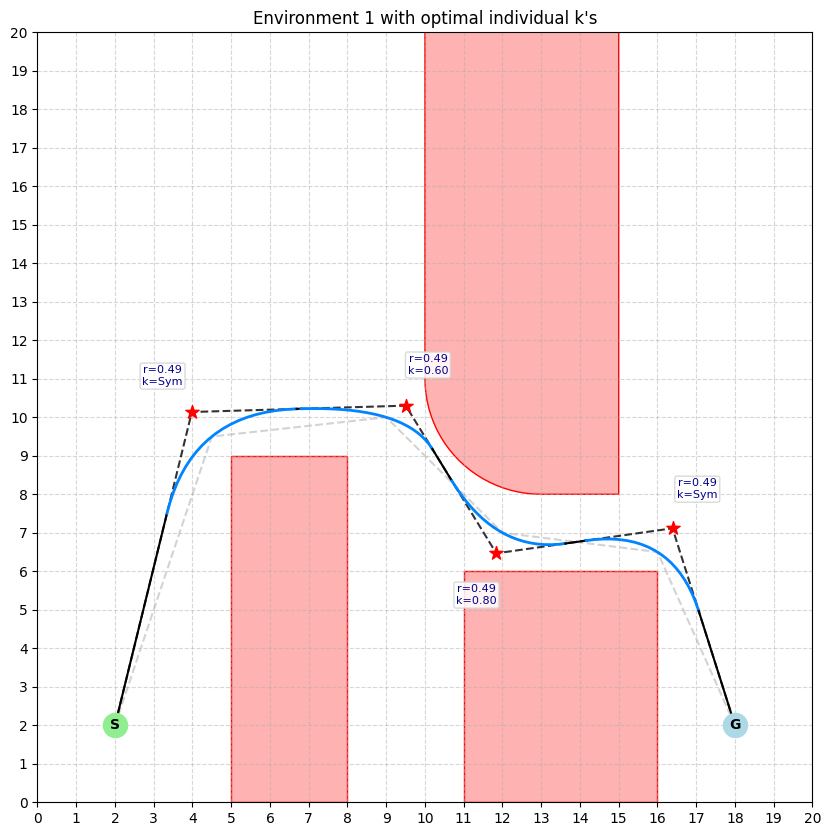

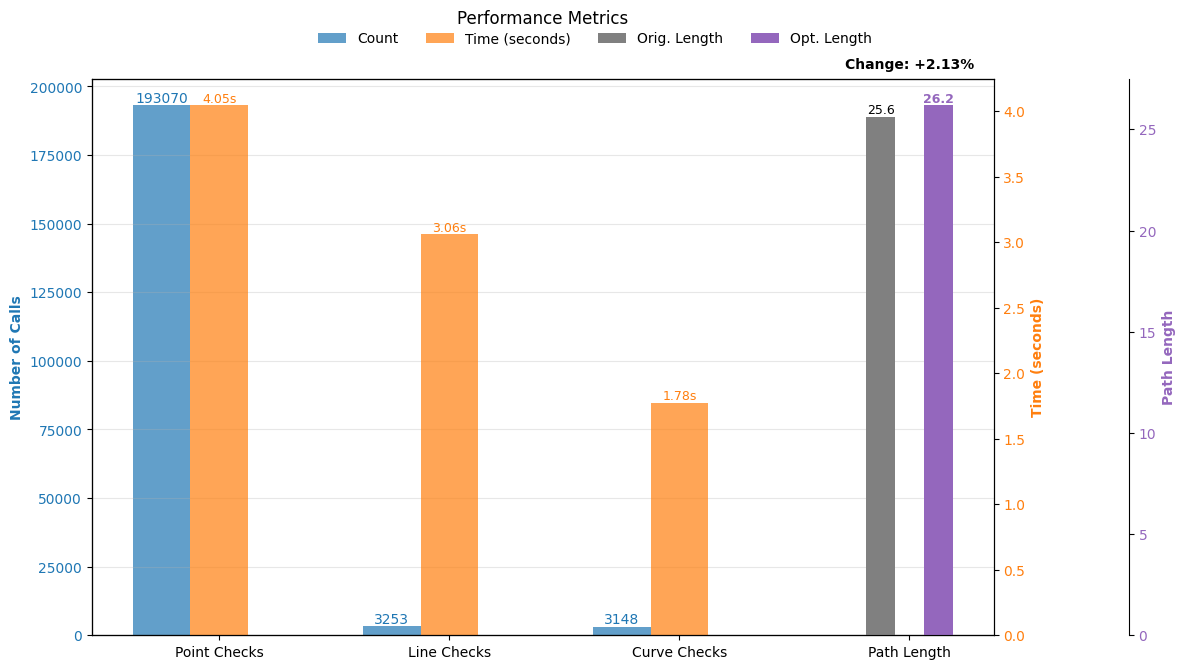

----------------------------------------
Optimizing Individual k's for Environment 2:
----------------------------------------


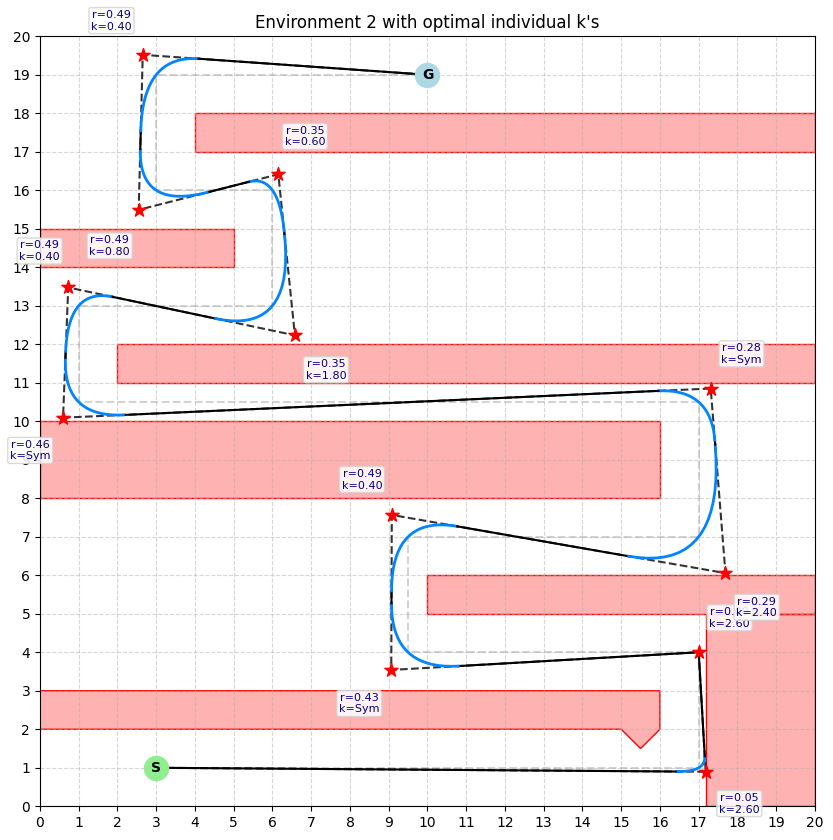

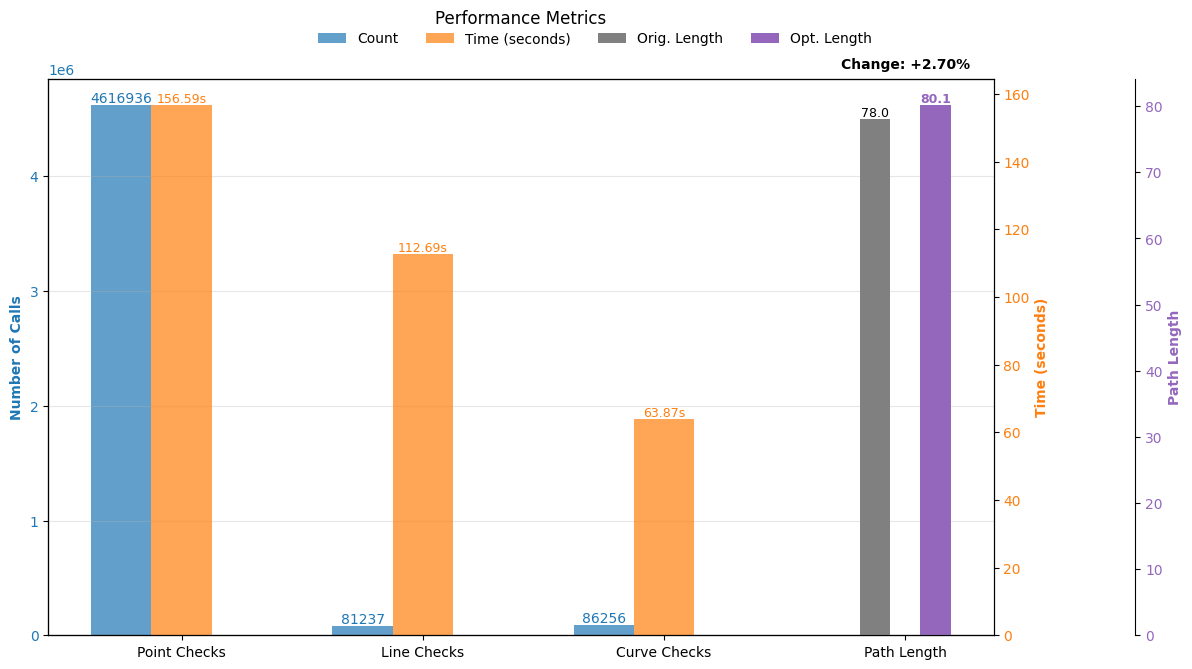

----------------------------------------
Optimizing Individual k's for Environment 3:
----------------------------------------


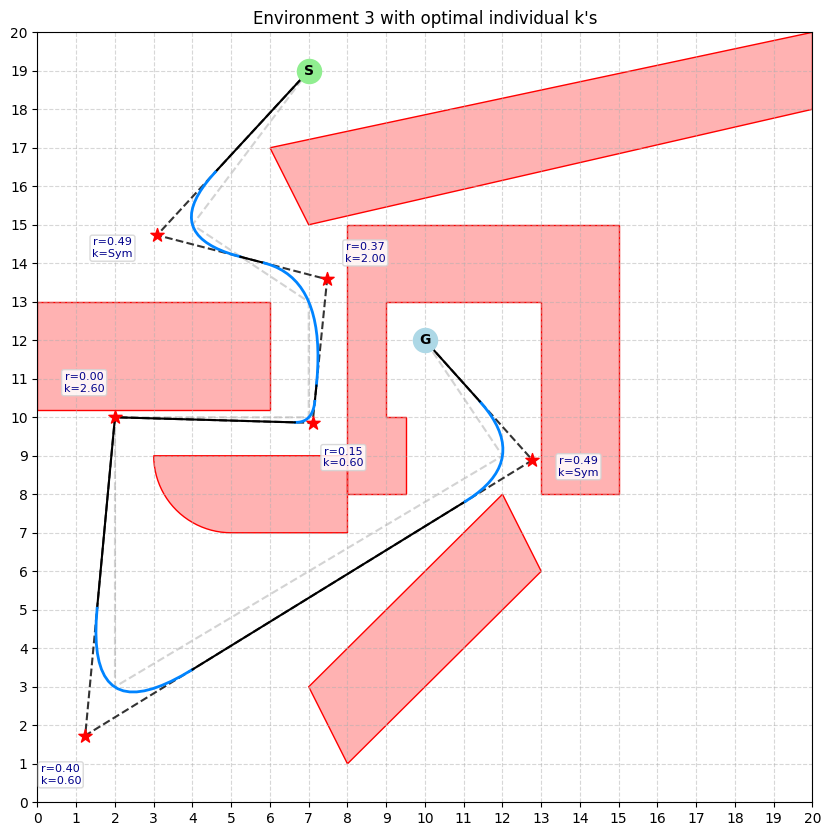

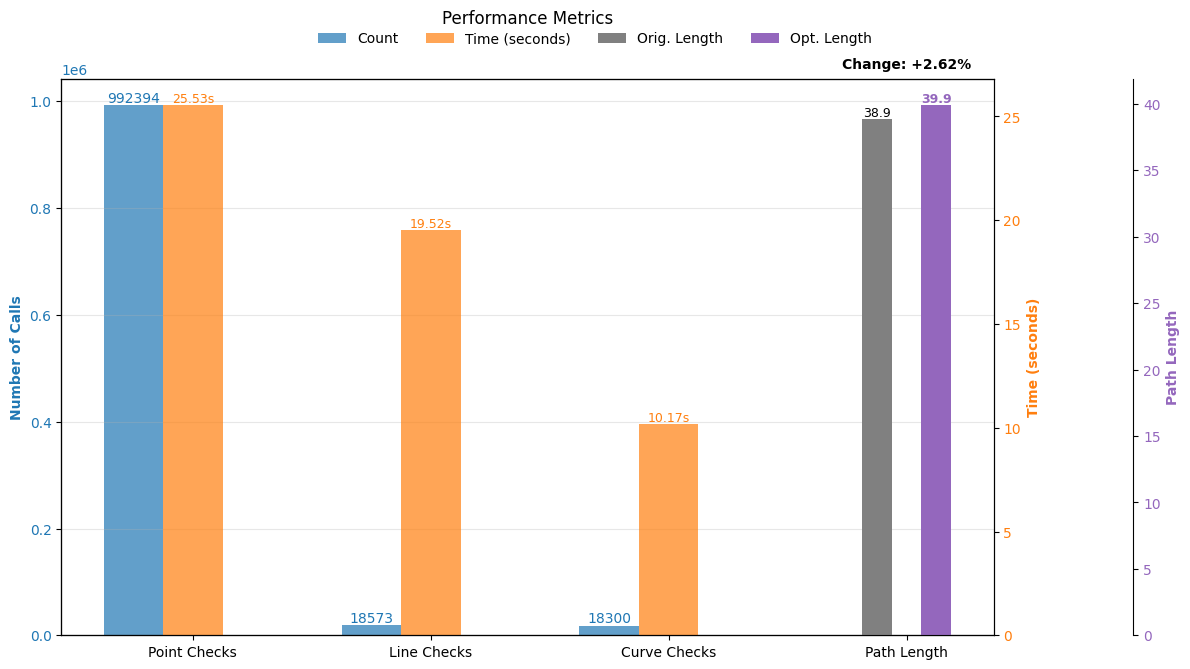

----------------------------------------
Optimizing Individual k's for Environment 4:
----------------------------------------


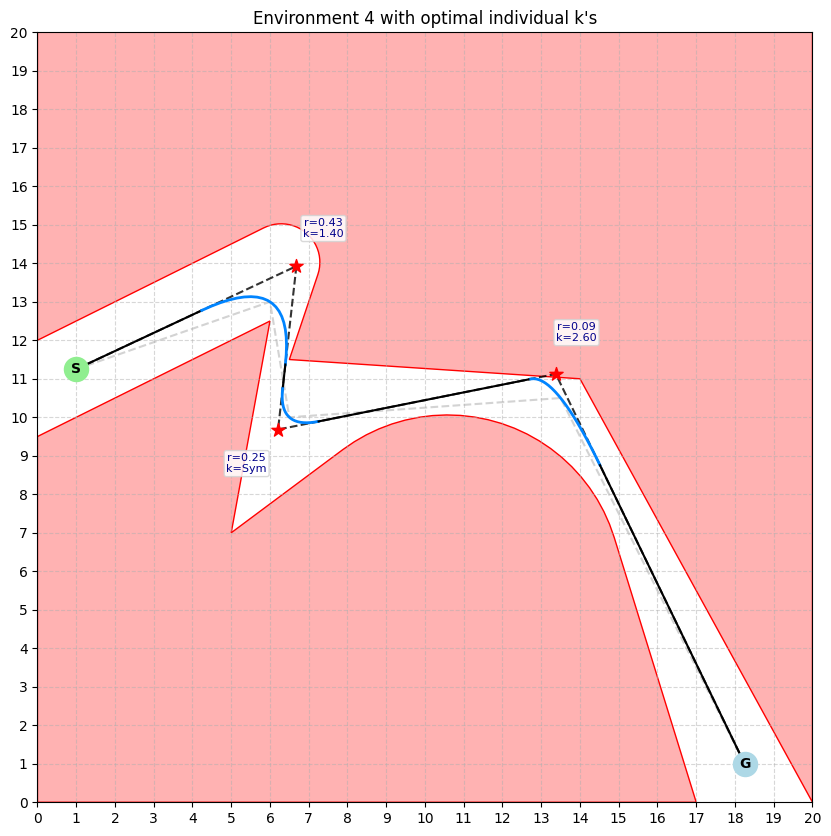

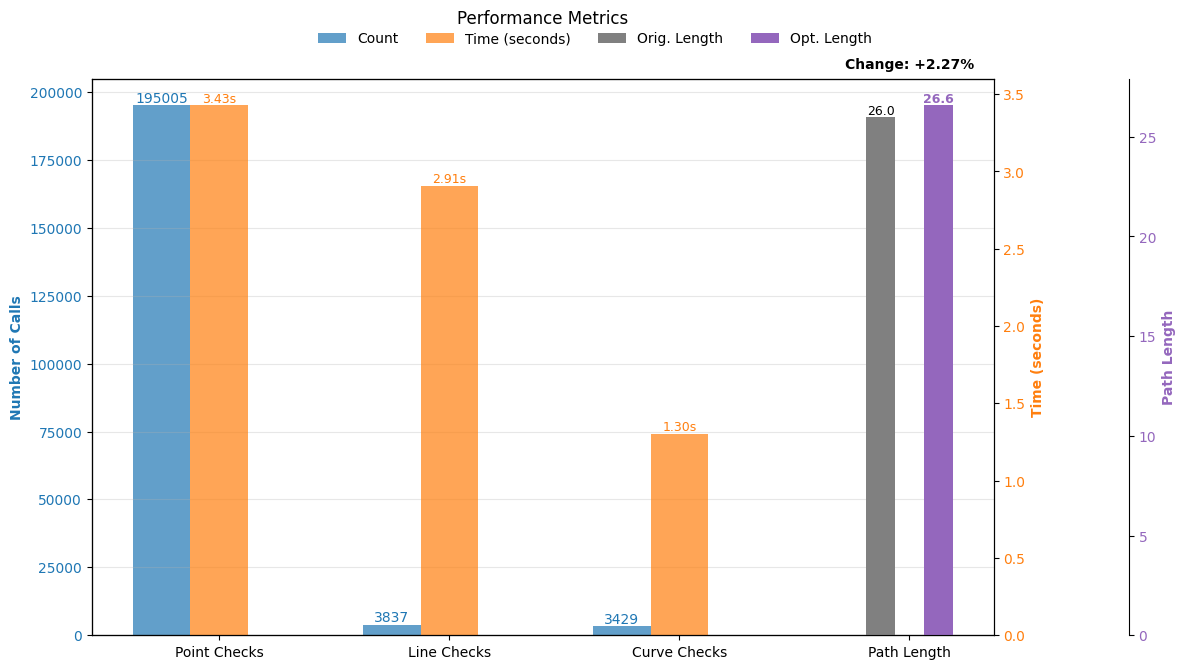

In [12]:
for name, item in env_dict.items():
    print(f"{40 * '-'}")
    print(f"Optimizing Individual k's for Environment {name}:")
    print(f"{40 * '-'}")

    # Extract objects from the dictionary for easier access
    env = item['env']
    node_names = item['solution_node_names']
    planner = item['planner']
    cc: CollisionChecker = planner._collisionChecker

    # Initialize the Optimizer
    optimizer = OptimizeFlyby()

    # Clear the Performance Monitor
    IPPerfMonitor.clearData()
    
    # Clear graph attributes
    clear_graph_attributes(planner)

    # Measure the optimization time for later analysis
    start_time = time.time()

    # Run the optimization
    results = optimizer.optimize_individual_k(node_names, planner, config={'r_init': 0.5})

    # Store the optimization time in the env_dict
    end_time = time.time()
    item['individual_k_time'] = end_time - start_time

    # Extract the performance data for plotting
    df = IPPerfMonitor.dataFrame()
    stats = {}
    target_funcs = ['lineInCollision', 'curveInCollision', 'pointInCollision']
    
    for f in target_funcs:
        f_data = df[df['name'] == f]
        if not f_data.empty:
            stats[f] = {
                'count': len(f_data), 
                'time': f_data['time'].sum()
            }
        else:
            stats[f] = {'count': 0, 'time': 0.0}

    # Calculate original path length
    len_orig = calculate_path_length(planner, node_names, use_curves=False)

    # Calculate optimized path lengthe (of rounded path)
    len_opt = calculate_path_length(planner, node_names, use_curves=True)

    # Store the path length for the optimized individual k's in the dictionary for later analysis
    item['individual_k_path_length'] = len_opt

    # Draw the obstacles
    ax = cc.draw_enviroments()

    # Draw the optimized path
    ax = cc.draw_optimized_path(results, planner, ax)

    # Set the title
    ax.set_title(f"Environment {name} with optimal individual k's")

    # Show the plot
    plt.show()

    # Plot the performance data
    plot_performance_data(stats, len_orig, len_opt)

## Comparison between Original Path - Symmetric k - Global Optimal k - Individual Optimal k

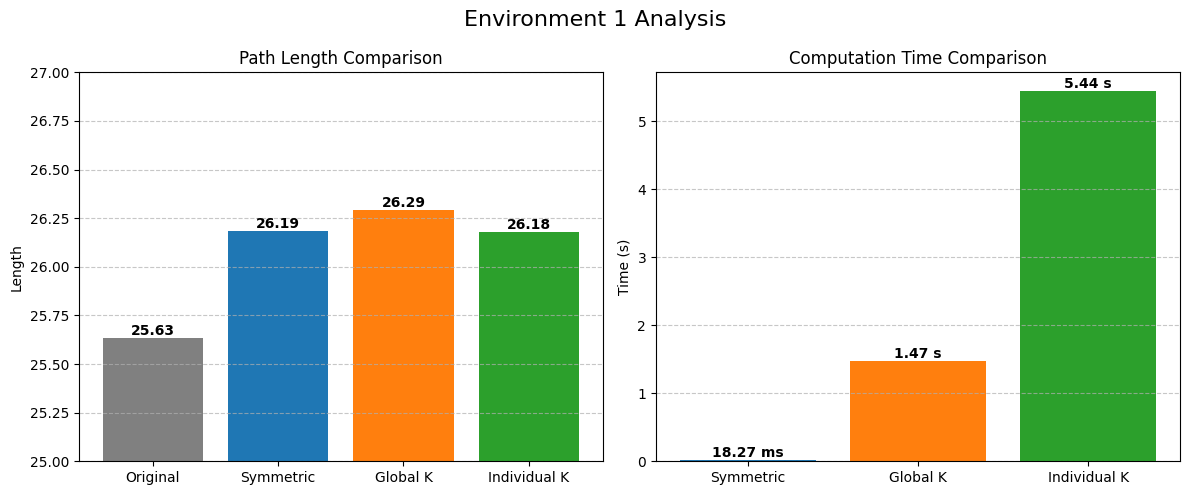

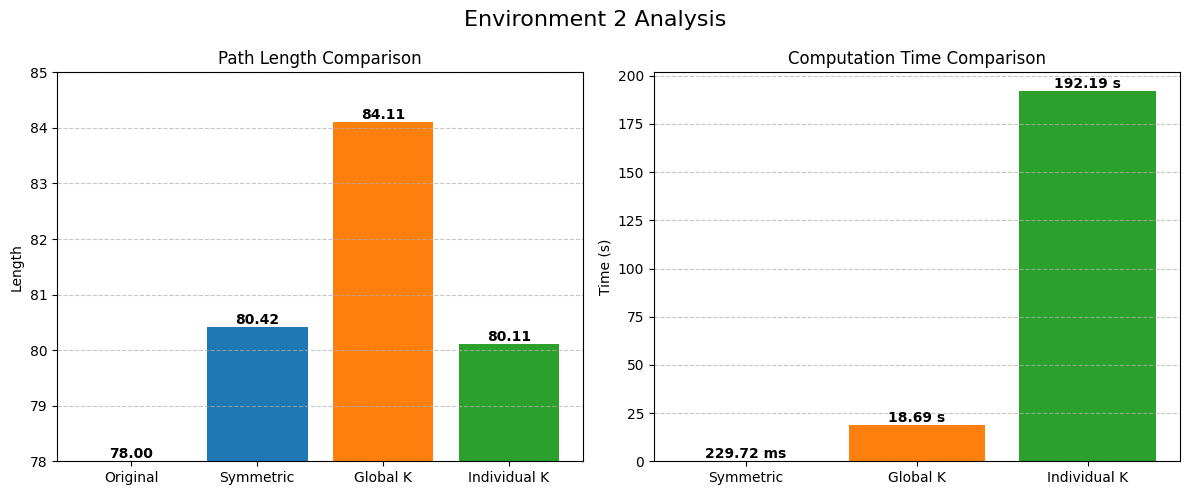

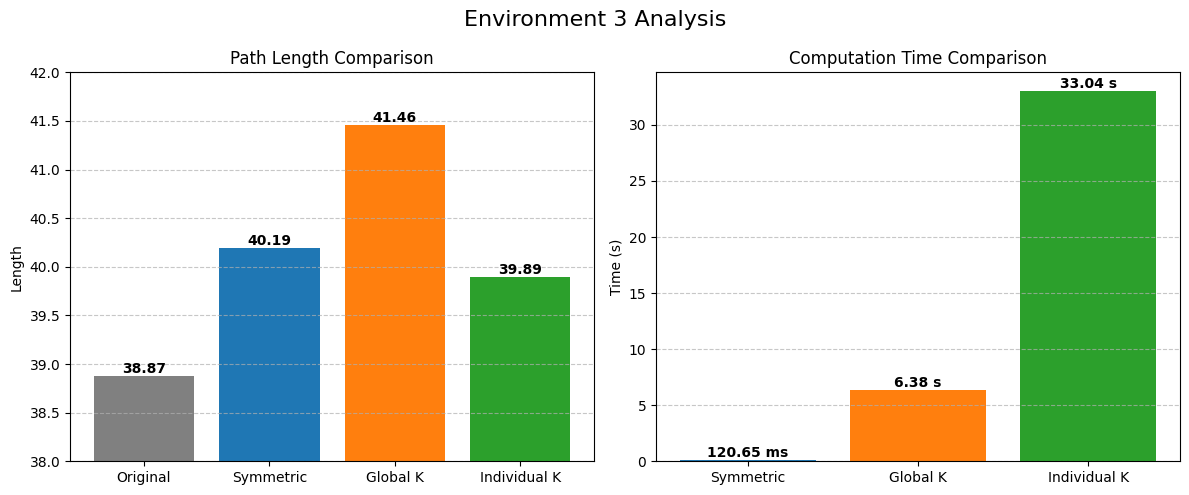

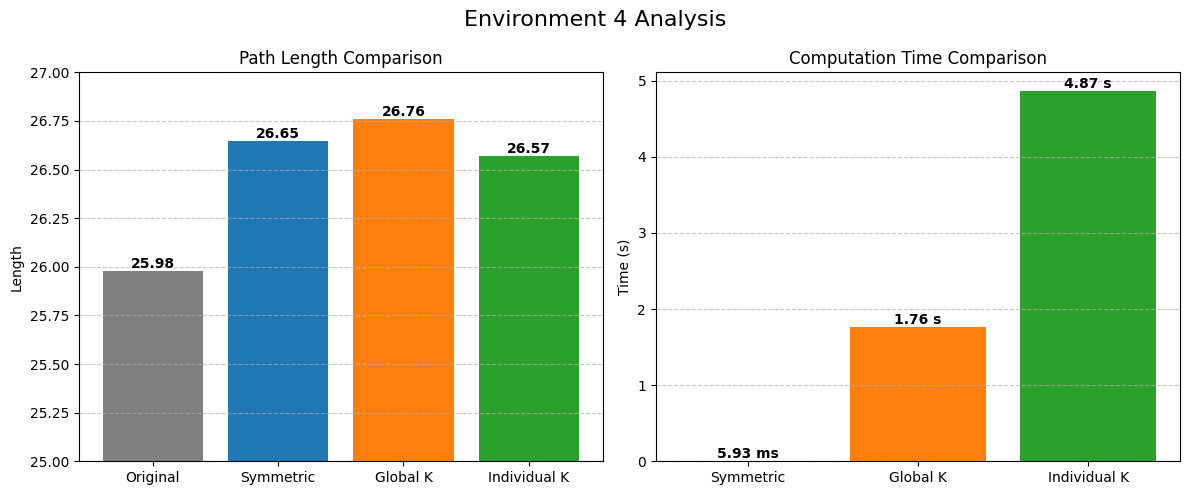

In [13]:
for name, item in env_dict.items():
    
    # Extract path length data
    lengths = [
        item['orignal_path_length'],
        item['symmetric_path_length'],
        item['global_k_path_length'],
        item['individual_k_path_length']
    ]
    length_labels = ['Original', 'Symmetric', 'Global K', 'Individual K']

    # Extract optimization time data
    times = [
        item['symmetric_time'],
        item['global_k_time'],
        item['individual_k_time']
    ]
    time_labels = ['Symmetric', 'Global K', 'Individual K']
    
    # Create plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Environment {name} Analysis', fontsize=16)

    # Plot the path lengths
    colors_len = ['gray', 'tab:blue', 'tab:orange', 'tab:green']
    ax1.bar(length_labels, lengths, color=colors_len)
    
    # Set the y limits for the lengths
    y_min = math.floor(min(lengths))
    y_max = math.ceil(max(lengths))
    
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_title('Path Length Comparison')
    ax1.set_ylabel('Length')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels (Length)
    for i, v in enumerate(lengths):
        ax1.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

    # Plot the optimization time
    colors_time = ['tab:blue', 'tab:orange', 'tab:green']
    ax2.bar(time_labels, times, color=colors_time)
    ax2.set_title('Computation Time Comparison')
    ax2.set_ylabel('Time (s)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text labels above bars (convert to ms if <1s)
    for i, v in enumerate(times):
        # Determine unit and formatting
        if v < 1.0:
            label = f"{v * 1000:.2f} ms"
        else:
            label = f"{v:.2f} s"
            
        ax2.text(i, v, label, ha='center', va='bottom', fontweight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

## Diskussion der lokalen Optimierung des Asymmetriefaktors (Aufgabe 2e)

Ergänzend zur globalen Optimierung wurde ein Verfahren implementiert, das für jeden Knoten einen individuellen, lokal optimalen Asymmetriefaktor $k$ bestimmt. Im Gegensatz zum globalen Ansatz, der einen Kompromiss für alle Kurven erzwingt, kann sich hier jede Kurve ideal an die lokale Geometrie (z.B. spitzer vs. stumpfer Winkel, lange vs. kurze angrenzende Segmente) anpassen.

### Methodik: Coordinate Descent

Da die Wahl des Faktors $k$ an einem Knoten $i$ durch die Verschiebung des virtuellen Kontrollpunktes $P_{2n}$ auch die Geometrie der angrenzenden Segmente und damit die optimalen Parameter der Nachbarknoten beeinflusst, lassen sich die Ecken nicht unabhängig voneinander optimieren.

Zur Lösung dieses Problems wurde ein **Coordinate Descent Algorithmus** implementiert (siehe `optimize_individual_k`):

1.  **Iteratives Vorgehen:** Der Algorithmus iteriert sequenziell über alle Wegpunkte des Pfades.
2.  **Lokale Evaluation:** An jedem Knoten wird eine Reihe von Kandidaten für $k$ (Standardbereich $0.4$ bis $2.6$ sowie die dynamische Symmetrie) getestet.
3.  **Globale Bewertung:** Für jeden Kandidaten wird temporär eine vollständige Pfadberechnung durchgeführt. Bewertungskriterium ist dabei die **Gesamtlänge des Pfades**. Es wird derjenige $k$-Wert fest eingeloggt, der die Gesamtlänge minimiert.
4.  **Konvergenz:** Da die Änderung eines Knotens neue Potenziale bei den Nachbarn freisetzen kann, wird dieser Prozess in mehreren Durchläufen (Passes) wiederholt, bis sich die Pfadlänge nicht mehr signifikant verbessert.

### Analyse der Ergebnisse

Die iterative Suche nach lokalen Optima liefert erwartungsgemäß die kürzesten Pfade unter allen getesteten Varianten. Gegenüber dem ursprünglichen, ungeglätteten Pfad (lineare Referenz) ergeben sich folgende Verlängerungen:

* **Environment 1:** +2.15%
* **Environment 2:** +2.70%
* **Environment 3:** +2.65%
* **Environment 4:** +2.28%

Diese Werte stellen das geometrische Optimum des implementierten Fly-By-Verfahrens dar. Durch die individuelle Anpassung wird der "Overshoot" (das notwendige Ausholen nach außen) an jeder Ecke auf das absolute Minimum reduziert, das zur Vermeidung von Kollisionen notwendig ist.

### Aufwand-Nutzen-Diskussion

Der entscheidende Nachteil dieses Verfahrens liegt im massiv erhöhten Rechenaufwand.
Für jeden Knoten werden ca. 13 verschiedene $k$-Werte getestet. Bei jedem Test muss der gesamte Pfad relaxiert ("Inverse Rounding") und auf Kollisionen geprüft werden. Dies führt zu einer Laufzeit, die in den Experimenten um den Faktor **>100** höher lag als bei der Berechnung mit einem dynamischen oder globalen $k$.

## Fazit
Die lokale Optimierung demonstriert das theoretische Minimum der Pfadlänge. Für praktische Anwendungen, insbesondere wenn (Neu-)Planungszeit eine Rolle spielt, ist der Grenznutzen im Vergleich zum dynamischen Standardverfahren (`k=sym`) jedoch fraglich. Die dynamische Symmetrie liefert bereits sehr gute Ergebnisse bei einem Bruchteil der Rechenzeit. Der Einsatz des Coordinate Descent ist daher nur in Szenarien gerechtfertigt, in denen der Pfad einmalig offline berechnet wird und dann sehr häufig (z.B. in der Serienfertigung) zykluszeitkritisch abgefahren wird.

---

# Umsetzung auf einem Industrieroboter (Aufgabe 3)

Um die theoretisch berechneten Pfade in die Realität zu übertragen, müssen die Besonderheiten realer Manipulatoren berücksichtigt werden. Dieser Abschnitt beleuchtet die Unterschiede zwischen unserer vereinfachten Simulation und der physikalischen Ausführung sowie die Flexibilität des Algorithmus hinsichtlich der Ansteuerung.

## 1. Was ist ein Industrieroboter?

Ein Industrieroboter ist definitionsgemäß ein automatisch gesteuerter, wiederprogrammierbarer, vielfach einsetzbarer Manipulator, der in drei oder mehr Achsen programmierbar ist (vgl. ISO 8373). In der industriellen Praxis handelt es sich dabei häufig um serielle Kinematiken, wie etwa 6-Achs-Knickarmroboter. Der Zustand des Roboters wird primär durch seinen Gelenkvektor ($q_1, \dots, q_6$) beschrieben, während sich die Pose des Werkzeugs (TCP) erst über die Vorwärtskinematik aus dieser Konfiguration ergibt.

## 2. Übertragung des 2D-Punktroboter-Pfades (Arbeitsraum vs. Konfigurationsraum)

In unserer Simulation bewegen wir einen Punktroboter in einer 2D-Ebene $(x,y)$ ohne Ausdehnung und Orientierung. Dies stellt einen Sonderfall dar, in dem der Arbeitsraum (Workspace) mit dem Konfigurationsraum (C-Space) zusammenfällt.

Um diesen Pfad mit einem realen 6-Achs-Roboter abzufahren, müssen folgende Schritte erfolgen:

1.  **Erweiterung der Pose:** Der 2D-Pfad $(x, y)$ muss zu einer 3D-Pose $(x, y, z, A, B, C)$ erweitert werden. Typischerweise wird hierfür eine konstante Arbeitshöhe $z$ fixiert und eine konstante Orientierung des Werkzeugs (z. B. senkrecht zur Arbeitsfläche) festgelegt.
2.  **Transformation (Inverse Kinematik):** Da der Roboter über seine Gelenke gesteuert wird, müssen die kartesischen Koordinaten der geglätteten Bahn mittels Inverser Kinematik in zulässige Gelenkwinkel umgerechnet werden. 
3.  **Implizite Kollisionsprüfung:** Da ein realer Roboter eine physische Ausdehnung besitzt, muss validiert werden, ob die Bewegung der gesamten Roboterstruktur entlang der Bahn kollisionsfrei bleibt. Dies geschieht durch Diskretisierung der Bahnsegmente und Prüfung im Arbeitsraum mittels Vorwärtskinematik.


## 3. Dimensionsunabhängigkeit des Algorithmus

Ein entscheidender Vorteil des implementierten Glättungsalgorithmus (Bézier-Kurven und Inverse Rounding) ist, dass er mathematisch unabhängig von der Dimension des Raumes arbeitet. Die Vektorrechnung für die virtuellen Kontrollpunkte ($P_{2n}$) funktioniert für 6-dimensionale Gelenkwinkel-Vektoren ($q_1, \dots, q_6$) genauso wie für 2D-Koordinaten. Dies eröffnet zwei Strategien für die Ansteuerung:

### A. Exakte Vorgabe der Bahn (Interpolation)
Der Algorithmus berechnet die Punkte der Parabeln bereits extern vorberechnet (diskretisiert). Der Roboter erhält eine sehr dichte Folge von Stützpunkten, die er exakt abfährt (z. B. via `SPLINE` im Arbeitsraum oder dichter `PTP`-Folge). Dies garantiert, dass die Bewegung exakt der vorberechneten, kollisionsgeprüften Geometrie entspricht. Werden `PTP` Befehle verwendet, ist zu erwarten, dass Roboterarm sich nur stockend oder sehr langsame bewegt.

### B. Nutzung der steuerungsinternen Glättung (Approximation / PTP)
Alternativ kann die Glättungsfunktionalität der Industriesteuerung (z. B. KUKA `C_PTP` oder `C_DIS`) genutzt werden, um die Datenmenge gering zu halten. Hierbei ist jedoch ein entscheidender Schritt zu beachten, um das **Inverse Rounding** (Via-Point-Verhalten) beizubehalten:

Würde man der Steuerung die ursprünglichen Pfadpunkte ($P_{org}$) mit einem Überschleifradius übergeben, würde der Roboter die Ecken lediglich abschneiden ("Corner Cutting") und den gewünschten Wegpunkt verfehlen.
Stattdessen werden die durch unseren Algorithmus berechneten **virtuellen Kontrollpunkte** ($P_{2n}$) im Gelenkwinkelraum an die Steuerung übergeben.

* **Vorgehen:** Die Liste der Zielpunkte besteht aus den Koordinaten $P_{2n}$.
* **Parameter:** Der im Algorithmus ermittelte Radius $r$ wird in den steuerungsspezifischen Überschleifparameter (z. B. KUKA `$APO.CPTP` oder `C_PTP`) umgerechnet.
* **Effekt:** Der Roboter zielt auf den weit außen liegenden Punkt $P_{2n}$, beginnt aber frühzeitig mit dem Überschleifen. Durch die geometrische Konstruktion von $P_{2n}$ führt diese "Abkürzung" dazu, dass der Roboter den ursprünglich geplanten Punkt $P_{org}$ exakt berührt.

Mit diesem Vorgehen bleibt die Datenmenge, die and die Steuerung übergeben werden muss gering, da nur die Eckpunkte mit je einem Parameter für das Überschleifen übertragen werden müssen.

Da in der Praxis die internen Überschleifberechnungen von KUKA nicht exakt mit unserer Berechnung übereinstimmen und die exakte Berechnungsmethode von KUKA nicht bekannt ist, ist zu erwarten das die resultierende Bahn, die der Roboter fährt, nicht exakt der von unserem Algorithmus geplanten Bahn enspricht.


## 4. Vorteile des implementierten Algorithmus

Gegenüber klassischen Verfahren der Industriesteuerungen bietet unser Ansatz signifikante Vorteile:

* **Inverse Rounding vs. Corner Cutting:** Industriesteuerungen nutzen beim Überschleifen (Blending) oft ein "Abschneiden" der Ecken, wodurch der ursprüngliche Wegpunkt ($P_{org}$) verfehlt wird. Unser Algorithmus berechnet jedoch einen virtuellen Kontrollpunkt $P_{2n}$, der so weit nach außen geschoben wird, dass die resultierende Kurve den ursprünglichen Wegpunkt exakt berührt (Via-Point-Verhalten). Dies ist essenziell für Anwendungen, bei denen Positionen exakt durchfahren werden müssen (z. B. Kleben, Schweißen).
* **Reduzierte mechanische Belastung:** Durch die $G^1$-Stetigkeit (keine Knicke) und den stetigen Krümmungsverlauf der Parabeln werden ruckartige Beschleunigungen ($\ddot{q}$) in den Gelenken vermieden. Dies schont Getriebe und Mechanik erheblich.
* **Optimierte Zykluszeit:** Obwohl das "Inverse Rounding" die Wegstrecke geringfügig verlängert (ca. 2-3%), ermöglicht die stetige Bahnführung eine konstant hohe Bahngeschwindigkeit ohne Stopps an den Ecken. Dies führt in der Summe oft zu kürzeren Zykluszeiten als ein Stop-and-Go-Betrieb auf einer kürzeren, eckigen Bahn.
* **Nutzung des Asymmetriefaktors $k$:** Die Möglichkeit, Kurven mittels $k$ asymmetrisch zu gestalten, erlaubt es, auf die Dynamik unterschiedlicher Achsen einzugehen (z. B. langsame Hauptachsen vs. flinke Handachsen), um das "Ausschwingen" aus Kurven zu optimieren.